In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)

## Load Muse Embeddings

In [2]:
def read_muse_vecs(muse_file):
        with open(muse_file, 'r',  errors='ignore', encoding="utf-8") as f:
            words = set()
            word_to_vec_map = {}
            for line in f:
                line = line.strip().split()
                curr_word_list = line[0: len(line) - 300]
                curr_word = ""
                for t in curr_word_list:
                    curr_word = curr_word + str(t) + " "
                curr_word = curr_word.strip()
                words.add(curr_word)
                try:
                    word_to_vec_map[curr_word] = np.array(line[-300:], dtype=np.float64)
                except:
                    print(line, len(line))

            i = 1
            words_to_index = {}
            index_to_words = {}

            words.add("nokey")
            word_to_vec_map["nokey"] = np.zeros((300,), dtype=np.float64)

            for w in sorted(words):
                words_to_index[w] = i
                index_to_words[i] = w
                i = i + 1
        return words_to_index, index_to_words, word_to_vec_map

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Pathjup = "muse/data/wiki.en.vec"
Pathdrive = "/content/drive/MyDrive/muse/data/wiki.en.vec"

words_to_index, index_to_words, word_to_vec_map = read_muse_vecs(Pathdrive)

In [5]:
## Diccionario con word-embeddings(300)
#word_to_vec_map.keys()

In [6]:
len(words_to_index) # Tamaño del vocabulario ingles

199989

In [7]:
len(word_to_vec_map["no"]) # Embeddings palabra "right"

300

## Load Amazon Dataset English

In [11]:
path1 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/train/amazonEN_train.csv"
path2 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/valid/amazonEN_valid.csv"
path3 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonEN_test.csv"

In [12]:
df_train = pd.read_csv(path1)
df_valid = pd.read_csv(path2)
df_test = pd.read_csv(path3)

In [13]:
df_train.head(1)

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod
0,en_0522546,product_en_0681589,reviewer_en_0687817,2,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,en,lawn_and_garden,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,17


In [14]:
# POR AHORA NO 
#convert lables to one-hot vectors (to use categorical cross-entropy loss)

def convert_to_one_hot(y, C):
    Y = np.eye(C)[y.values.reshape(-1)]
    return Y

y_train_oh = convert_to_one_hot(y_train,C=5)
y_val_oh = convert_to_one_hot(y_val,C=5)

NameError: ignored

In [ ]:
X_train = df_train['review_body']
X_val= df_valid['review_body']
X_test= df_test['review_body']

y_train = df_train['star_rating']
y_val = df_valid['star_rating']
y_test= df_test['star_rating']

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

X_data_full = pd.concat([X_train, X_val, X_test],ignore_index=True)
t= Tokenizer()
t.fit_on_texts(X_data_full)
vocab_size = len(t.word_index)+1
max_length = 260

encoded_rev = t.texts_to_sequences(X_train)
padded_rev = pad_sequences(encoded_rev,maxlen=max_length,padding= 'post')

encoded_rev_val = t.texts_to_sequences(X_val)
padded_rev_val = pad_sequences(encoded_rev_val,maxlen=max_length,padding= 'post')

encoded_rev_test = t.texts_to_sequences(X_test)
padded_rev_test = pad_sequences(encoded_rev_test,maxlen=max_length,padding= 'post')

In [18]:
#Creamos matriz de embeddings a partir del vocab de las review_body FULL
from numpy import zeros
embedding_matrix = zeros((vocab_size,300))
for word, i in t.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [19]:
embedding_matrix.shape

(47071, 300)

In [20]:
vocab_size

47071

## Needed

In [21]:
!pip install keras

In [22]:
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
import os
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import RMSprop, SGD, Adam, Nadam

In [23]:
%%capture
!pip install wandb 
import wandb
from wandb.keras import WandbCallback

## RATING CLASSIFICATION
- Review_body

In [54]:
# Initialize wandb with your project name
run = wandb.init(project='MUSE embeddings model',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 5,
                     "batch_size": 128,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "LSTM"
                 })
config = wandb.config  # We'll use this to configure our experiment

epoch,1
loss,1.60932
accuracy,0.20018
val_loss,1.60925
val_accuracy,0.1888
_runtime,316
_timestamp,1615824443
_step,1
best_val_loss,1.60918
best_epoch,0


epoch,▁█
loss,█▁
accuracy,█▁
val_loss,▁█
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


### Embedding layer comun


Embedding layer comun para todos

In [39]:
from tensorflow.keras.layers import Embedding
num_tokens = vocab_size
embedding_dim = 300 
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### Clasificador simple - BASELINE 

- mucho overfitting

In [35]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import GlobalMaxPool1D


model= Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
model.add(embed)
model.add(Flatten())
#model.add(GlobalMaxPool1D())
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [36]:
model.summary()
model.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 260, 300)          14004600  
_________________________________________________________________
flatten (Flatten)            (None, 78000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               19968256  
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 33,974,141
Trainable params: 19,969,541
Non-trainable params: 14,004,600
_________________________________________________________________


In [37]:
model.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/10
1563/1563 [==============================] - 46s 29ms/step - loss: 1.3491 - accuracy: 0.4009 - val_loss: 1.2380 - val_accuracy: 0.4524
Epoch 2/10
1563/1563 [==============================] - 48s 31ms/step - loss: 1.1478 - accuracy: 0.5045 - val_loss: 1.2312 - val_accuracy: 0.4596
Epoch 3/10
1563/1563 [==============================] - 46s 30ms/step - loss: 1.0347 - accuracy: 0.5633 - val_loss: 1.2859 - val_accuracy: 0.4436
Epoch 4/10
1563/1563 [==============================] - 46s 29ms/step - loss: 0.9039 - accuracy: 0.6262 - val_loss: 1.3737 - val_accuracy: 0.4440
Epoch 5/10
1563/1563 [==============================] - 46s 29ms/step - loss: 0.7495 - accuracy: 0.7020 - val_loss: 1.5454 - val_accuracy: 0.4440
Epoch 6/10
1563/1563 [==============================] - 46s 29ms/step - loss: 0.5958 - accuracy: 0.7734 - val_loss: 1.7630 - val_accuracy: 0.4180
Epoch 7/10
1563/1563 [==============================] - 46s 29ms/step - loss: 0.4536 - accuracy: 0.8379 - val_loss: 1.9839 -

### LSTMs

In [49]:
#Modelo
from keras.models import Sequential
from keras.layers import SpatialDropout1D
model = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
model.add(embed)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128,return_sequences=False))
#model.add(Dropout(0.4))
#model.add(LSTM(128,return_sequences=False))
#model.add(Dropout(0.4))
model.add(Dense(5,activation='softmax'))

In [50]:
model.summary()
model.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 260, 300)          14004600  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 260, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 14,224,893
Trainable params: 220,293
Non-trainable params: 14,004,600
_________________________________________________________________


In [51]:
model.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/10
1563/1563 [==============================] - 127s 80ms/step - loss: 1.6103 - accuracy: 0.1995 - val_loss: 1.6092 - val_accuracy: 0.1996
Epoch 2/10
1563/1563 [==============================] - 124s 80ms/step - loss: 1.6093 - accuracy: 0.2013 - val_loss: 1.6092 - val_accuracy: 0.1888
Epoch 3/10
  89/1563 [>.............................] - ETA: 1:56 - loss: 1.6093 - accuracy: 0.2081

KeyboardInterrupt: ignored

### GRUs

In [58]:
#Modelo  GRU
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional
from keras.layers import GRU

modelgru = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
modelgru.add(embed)
modelgru.add(SpatialDropout1D(0.2))
modelgru.add(GRU(256, return_sequences=False))
modelgru.add(Dropout(0.3))
#modelgru.add(GRU(128, return_sequences=False))
#modelgru.add(Dropout(0.4))
modelgru.add(Dense(5,activation='softmax'))

In [59]:
modelgru.summary()
modelgru.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 260, 300)          14004600  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 260, 300)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               428544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 1285      
Total params: 14,434,429
Trainable params: 429,829
Non-trainable params: 14,004,600
_________________________________________________________________


In [60]:
modelgru.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/5
1563/1563 [==============================] - 183s 116ms/step - loss: 1.6099 - accuracy: 0.2008 - val_loss: 1.6092 - val_accuracy: 0.2080
Epoch 2/5
1254/1563 [=======================>......] - ETA: 35s - loss: 1.6096 - accuracy: 0.1996

KeyboardInterrupt: ignored

### Bi-LSTM 

In [40]:
#Modelo mejorado bi-lstm
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import GlobalMaxPool1D

modelbi = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
modelbi.add(embed)
modelbi.add(Bidirectional(LSTM(128,return_sequences=True)))
modelbi.add(GlobalMaxPool1D())
modelbi.add(Dropout(0.4))
#modelbi.add(Bidirectional(LSTM(128,return_sequences=True)))
#modelbi.add(Dropout(0.4))
modelbi.add(Dense(100,activation='relu'))
modelbi.add(Dense(5,activation='softmax'))

In [41]:
modelbi.summary()
modelbi.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 260, 300)          14004600  
_________________________________________________________________
bidirectional (Bidirectional (None, 260, 256)          439296    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 505       
Total params: 14,470,101
Trainable params: 465,501
Non-trainable params: 14,004,600
____________________________________

In [42]:
modelbi.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/10
1563/1563 [==============================] - 265s 151ms/step - loss: 1.2917 - accuracy: 0.4255 - val_loss: 1.0890 - val_accuracy: 0.5240
Epoch 2/10
1563/1563 [==============================] - 235s 150ms/step - loss: 1.0936 - accuracy: 0.5207 - val_loss: 1.0576 - val_accuracy: 0.5412
Epoch 3/10
1563/1563 [==============================] - 235s 151ms/step - loss: 1.0522 - accuracy: 0.5377 - val_loss: 1.0608 - val_accuracy: 0.5336
Epoch 4/10
1563/1563 [==============================] - 234s 150ms/step - loss: 1.0320 - accuracy: 0.5491 - val_loss: 1.0229 - val_accuracy: 0.5396
Epoch 5/10
1563/1563 [==============================] - 236s 151ms/step - loss: 1.0166 - accuracy: 0.5553 - val_loss: 1.0236 - val_accuracy: 0.5468
Epoch 6/10
1563/1563 [==============================] - 237s 152ms/step - loss: 0.9998 - accuracy: 0.5630 - val_loss: 1.0233 - val_accuracy: 0.5448
Epoch 7/10
1563/1563 [==============================] - 238s 152ms/step - loss: 0.9889 - accuracy: 0.5647 - val_

In [62]:
#loss,acc = modelbi.evaluate(x=padded_rev_test, y=y_test, batch_size=64, verbose=1)

## RATING CLASSIFICATION
- Review_body + review_title


In [63]:
X_train = df_train['text_title']
X_val= df_valid['text_title']
X_test= df_test['text_title']

y_train = df_train['star_rating']
y_val = df_valid['star_rating']
y_test= df_test['star_rating']

#convert lables to one-hot vectors (to use categorical cross-entropy loss)

def convert_to_one_hot(y, C):
    Y = np.eye(C)[y.values.reshape(-1)]
    return Y

y_train_oh = convert_to_one_hot(y_train,C=5)
y_val_oh = convert_to_one_hot(y_val,C=5)


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

X_data_full = pd.concat([X_train, X_val, X_test],ignore_index=True)
t= Tokenizer()
t.fit_on_texts(X_data_full)
vocab_size = len(t.word_index)+1
max_length = 260

encoded_rev = t.texts_to_sequences(X_train)
padded_rev = pad_sequences(encoded_rev,maxlen=max_length,padding= 'post')

encoded_rev_val = t.texts_to_sequences(X_val)
padded_rev_val = pad_sequences(encoded_rev_val,maxlen=max_length,padding= 'post')

encoded_rev_test = t.texts_to_sequences(X_test)
padded_rev_test = pad_sequences(encoded_rev_test,maxlen=max_length,padding= 'post')


In [64]:
#Creamos matriz de embeddings a partir del vocab de las text_title FULL
from numpy import zeros
embedding_matrix = zeros((vocab_size,300))
for word, i in t.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [79]:
# Initialize wandb with your project name
run = wandb.init(project='MUSE Embeddings model body_and_title',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 5,
                     "batch_size": 128,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "LSTM"
                 })
config = wandb.config  # We'll use this to configure our experiment


epoch,3
loss,0.90309
accuracy,0.20982
val_loss,0.9329
val_accuracy,0.13
_runtime,1468
_timestamp,1615827122
_step,13
best_val_loss,0.93046
best_epoch,2


epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃
loss,█▇▆▅▄▃▂▂▁▁█▇▇▇
accuracy,▄▄▅▆▆▇▇███▁▁▁▁
val_loss,▁▂▂▂▃▄▅▆▇█▁▁▁▁
val_accuracy,█████▇▇▇▇▇▃▃▂▁
_runtime,▁▁▁▂▂▂▂▃▃▃▅▆▇█
_timestamp,▁▁▁▂▂▂▂▃▃▃▅▆▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


### Modelo

Embedding layer

In [80]:
from tensorflow.keras.layers import Embedding
num_tokens = vocab_size 
embedding_dim = 300 
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### Clasificador simple

In [72]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l2

model = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
model.add(embed)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [73]:
model.summary()
model.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 260, 300)          14604300  
_________________________________________________________________
flatten_2 (Flatten)          (None, 78000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               19968256  
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 1285      
Total params: 34,573,841
Trainable params: 19,969,541
Non-trainable params: 14,604,300
_________________________________________________________________


In [74]:
model.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/10
1563/1563 [==============================] - 44s 28ms/step - loss: 1.1974 - accuracy: 0.4782 - val_loss: 1.0590 - val_accuracy: 0.5312
Epoch 2/10
1563/1563 [==============================] - 45s 29ms/step - loss: 0.9507 - accuracy: 0.5927 - val_loss: 1.0805 - val_accuracy: 0.5384
Epoch 3/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.8425 - accuracy: 0.6472 - val_loss: 1.1438 - val_accuracy: 0.5320
Epoch 4/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.7081 - accuracy: 0.7133 - val_loss: 1.2551 - val_accuracy: 0.5220
Epoch 5/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.5595 - accuracy: 0.7845 - val_loss: 1.4114 - val_accuracy: 0.5164
Epoch 6/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.4091 - accuracy: 0.8528 - val_loss: 1.6451 - val_accuracy: 0.5048
Epoch 7/10
1563/1563 [==============================] - 44s 28ms/step - loss: 0.2861 - accuracy: 0.9073 - val_loss: 1.9653 -

### LSTMs

In [ ]:
#Modelo 
from keras.models import Sequential
model = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
model.add(embed)
model.add(LSTM(256,return_sequences=False))
model.add(Dropout(0.4))
#model.add(LSTM(128,return_sequences=False))
#model.add(Dropout(0.4))
model.add(Dense(5,activation='softmax'))

In [ ]:
model.summary()
model.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 260, 300)          14484600  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               570368    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 15,056,253
Trainable params: 571,653
Non-trainable params: 14,484,600
_________________________________________________________________


In [ ]:
model.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/5
1563/1563 [==============================] - 115s 53ms/step - loss: 1.6097 - accuracy: 0.1996 - val_loss: 1.6097 - val_accuracy: 0.2096
Epoch 2/5
1563/1563 [==============================] - 83s 53ms/step - loss: 1.6096 - accuracy: 0.1996 - val_loss: 1.6093 - val_accuracy: 0.2088
Epoch 3/5
1563/1563 [==============================] - 83s 53ms/step - loss: 1.6094 - accuracy: 0.1997 - val_loss: 1.6094 - val_accuracy: 0.1996
Epoch 4/5
1563/1563 [==============================] - 83s 53ms/step - loss: 1.6092 - accuracy: 0.2014 - val_loss: 1.6097 - val_accuracy: 0.1984
Epoch 5/5
1563/1563 [==============================] - 83s 53ms/step - loss: 1.6093 - accuracy: 0.2015 - val_loss: 1.6095 - val_accuracy: 0.2000


###  Bi-LSTM 

In [81]:
#Modelo mejorado bi-lstm
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional

modelbi = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
modelbi.add(embed)
#modelbi.add(SpatialDropout1D(0.2))
modelbi.add(Bidirectional(LSTM(128,return_sequences=False)))
modelbi.add(Dropout(0.4))
modelbi.add(Dense(256,activation='relu'))
#modelbi.add(Bidirectional(LSTM(128,return_sequences=False)))
#modelbi.add(Dropout(0.4))

modelbi.add(Dense(5,activation='softmax'))

In [82]:
modelbi.summary()
modelbi.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 260, 300)          14604300  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 1285      
Total params: 15,110,673
Trainable params: 506,373
Non-trainable params: 14,604,300
_________________________________________________________________


In [83]:
modelbi.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/5
1563/1563 [==============================] - 229s 145ms/step - loss: 1.1870 - accuracy: 0.4804 - val_loss: 1.0129 - val_accuracy: 0.5508
Epoch 2/5
1563/1563 [==============================] - 225s 144ms/step - loss: 0.9766 - accuracy: 0.5717 - val_loss: 0.9644 - val_accuracy: 0.5724
Epoch 3/5
1563/1563 [==============================] - 225s 144ms/step - loss: 0.9321 - accuracy: 0.5918 - val_loss: 0.9338 - val_accuracy: 0.5916
Epoch 4/5
1563/1563 [==============================] - 225s 144ms/step - loss: 0.9198 - accuracy: 0.5986 - val_loss: 0.9525 - val_accuracy: 0.5744
Epoch 5/5
1563/1563 [==============================] - 225s 144ms/step - loss: 0.9151 - accuracy: 0.5990 - val_loss: 0.9484 - val_accuracy: 0.5748


### GRUs

In [ ]:
#Modelo mejorado GRU
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional
from keras.layers import GRU

modelgru = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
modelgru.add(embed)
modelgru.add(GRU(256, return_sequences=False))
#modelgru.add(Dropout(0.3))
#modelgru.add(GRU(512, return_sequences=True))
#modelgru.add(Dropout(0.4))
#modelgru.add(Bidirectional(LSTM(128,return_sequences=False)))
modelgru.add(Dense(5,activation='softmax'))

In [ ]:
modelgru.summary()
modelgru.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 260, 300)          14484600  
_________________________________________________________________
gru (GRU)                    (None, 256)               428544    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 14,914,429
Trainable params: 429,829
Non-trainable params: 14,484,600
_________________________________________________________________


In [ ]:
modelgru.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/5
1563/1563 [==============================] - 72s 45ms/step - loss: 1.6097 - accuracy: 0.1980 - val_loss: 1.6090 - val_accuracy: 0.2084
Epoch 2/5
1563/1563 [==============================] - 70s 45ms/step - loss: 1.6093 - accuracy: 0.2007 - val_loss: 1.6091 - val_accuracy: 0.1964
Epoch 3/5
1563/1563 [==============================] - 71s 45ms/step - loss: 1.6099 - accuracy: 0.1993 - val_loss: 1.6093 - val_accuracy: 0.2084
Epoch 4/5
1563/1563 [==============================] - 70s 45ms/step - loss: 1.6090 - accuracy: 0.2023 - val_loss: 1.6100 - val_accuracy: 0.2000
Epoch 5/5
1563/1563 [==============================] - 70s 45ms/step - loss: 1.6087 - accuracy: 0.2010 - val_loss: 1.6101 - val_accuracy: 0.1884


## RATING CLASSIFICATION
- Review_body + title + category


In [84]:
X_train = df_train['text_title_cat']
X_val= df_valid['text_title_cat']
X_test= df_test['text_title_cat']

y_train = df_train['star_rating']
y_val = df_valid['star_rating']
y_test= df_test['star_rating']


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#convert lables to one-hot vectors (to use categorical cross-entropy loss)

def convert_to_one_hot(y, C):
    Y = np.eye(C)[y.values.reshape(-1)]
    return Y

y_train_oh = convert_to_one_hot(y_train,C=5)
y_val_oh = convert_to_one_hot(y_val,C=5)


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

X_data_full = pd.concat([X_train, X_val, X_test],ignore_index=True)
t= Tokenizer()
t.fit_on_texts(X_data_full)
vocab_size = len(t.word_index)+1
max_length = 260

encoded_rev = t.texts_to_sequences(X_train)
padded_rev = pad_sequences(encoded_rev,maxlen=max_length,padding= 'post')

encoded_rev_val = t.texts_to_sequences(X_val)
padded_rev_val = pad_sequences(encoded_rev_val,maxlen=max_length,padding= 'post')

encoded_rev_test = t.texts_to_sequences(X_test)
padded_rev_test = pad_sequences(encoded_rev_test,maxlen=max_length,padding= 'post')



In [85]:
#Creamos matriz de embeddings a partir del vocab de las text_title_cat FULL
from numpy import zeros
embedding_matrix = zeros((vocab_size,300))
for word, i in t.word_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [86]:
# Initialize wandb with your project name
run = wandb.init(project='MUSE embeddings model body_title_cat',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 128,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "LSTM"
                 })
config = wandb.config  # We'll use this to configure our experiment


epoch,4
loss,0.9123
accuracy,0.60154
val_loss,0.94837
val_accuracy,0.5748
_runtime,1148
_timestamp,1615828487
_step,4
best_val_loss,0.93375
best_epoch,2


epoch,▁▃▅▆█
loss,█▃▂▂▁
accuracy,▁▆▇▇█
val_loss,█▄▁▃▂
val_accuracy,▁▅█▅▅
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


### Modelo

Embedding layer

In [87]:
from tensorflow.keras.layers import Embedding
num_tokens = vocab_size 
embedding_dim = 300 
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### Clasificador simple

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l2

model = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
model.add(embed)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [ ]:
model.summary()
model.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 260, 300)          14004600  
_________________________________________________________________
flatten_7 (Flatten)          (None, 78000)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 300)               23400300  
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1505      
Total params: 37,406,405
Trainable params: 23,401,805
Non-trainable params: 14,004,600
_________________________________________________________________


In [ ]:
model.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/7
3125/3125 [==============================] - 36s 11ms/step - loss: 1.3385 - accuracy: 0.4065 - val_loss: 1.2398 - val_accuracy: 0.4480
Epoch 2/7
3125/3125 [==============================] - 37s 12ms/step - loss: 1.1438 - accuracy: 0.5046 - val_loss: 1.2345 - val_accuracy: 0.4592
Epoch 3/7
3125/3125 [==============================] - 36s 12ms/step - loss: 1.0211 - accuracy: 0.5664 - val_loss: 1.2943 - val_accuracy: 0.4440
Epoch 4/7
3125/3125 [==============================] - 35s 11ms/step - loss: 0.8650 - accuracy: 0.6419 - val_loss: 1.4058 - val_accuracy: 0.4436
Epoch 5/7
3125/3125 [==============================] - 35s 11ms/step - loss: 0.6963 - accuracy: 0.7226 - val_loss: 1.6207 - val_accuracy: 0.4380
Epoch 6/7
3125/3125 [==============================] - 36s 11ms/step - loss: 0.5255 - accuracy: 0.8021 - val_loss: 1.8740 - val_accuracy: 0.4260
Epoch 7/7
3125/3125 [==============================] - 35s 11ms/step - loss: 0.3855 - accuracy: 0.8645 - val_loss: 2.2557 - val_ac

###  LSTMs

In [ ]:
#Modelo baseline
from keras.models import Sequential
model = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
model.add(embed)
model.add(LSTM(128,return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(5,activation='sigmoid'))

In [ ]:
model.summary()
model.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 260, 300)          14004600  
_________________________________________________________________
lstm (LSTM)                  (None, 260, 128)          219648    
_________________________________________________________________
dropout (Dropout)            (None, 260, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 14,356,477
Trainable params: 351,877
Non-trainable params: 14,004,600
______________________________________

In [ ]:
model.fit(padded_rev, y_train_oh, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val_oh), callbacks=[WandbCallback()])

Epoch 1/7
3125/3125 [==============================] - 174s 46ms/step - loss: 1.6100 - accuracy: 0.2006 - val_loss: 1.6099 - val_accuracy: 0.2080
Epoch 2/7
3125/3125 [==============================] - 141s 45ms/step - loss: 1.6097 - accuracy: 0.1986 - val_loss: 1.6091 - val_accuracy: 0.1964
Epoch 3/7
3125/3125 [==============================] - 140s 45ms/step - loss: 1.6096 - accuracy: 0.1989 - val_loss: 1.6093 - val_accuracy: 0.1988
Epoch 4/7
3125/3125 [==============================] - 139s 44ms/step - loss: 1.6095 - accuracy: 0.2001 - val_loss: 1.6085 - val_accuracy: 0.1892
Epoch 5/7
3125/3125 [==============================] - 140s 45ms/step - loss: 1.6070 - accuracy: 0.2063 - val_loss: 1.3998 - val_accuracy: 0.3652
Epoch 6/7
3125/3125 [==============================] - 141s 45ms/step - loss: 1.4480 - accuracy: 0.3212 - val_loss: 1.3663 - val_accuracy: 0.3768
Epoch 7/7
3125/3125 [==============================] - 142s 45ms/step - loss: 1.3640 - accuracy: 0.3625 - val_loss: 1.1970 -

###  Bi-LSTM 

In [88]:
#Modelo mejorado bi-lstm
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional

modelbi = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
modelbi.add(embed)
modelbi.add(Bidirectional(LSTM(128,return_sequences=False)))
modelbi.add(Dropout(0.4))
#modelbi.add(Bidirectional(LSTM(128,return_sequences=False)))
#modelbi.add(Dropout(0.4))
modelbi.add(Dense(5,activation='softmax'))

In [89]:
modelbi.summary()
modelbi.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 260, 300)          14604300  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 1285      
Total params: 15,044,881
Trainable params: 440,581
Non-trainable params: 14,604,300
_________________________________________________________________


In [90]:
modelbi.fit(padded_rev, y_train, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val), callbacks=[WandbCallback()])

Epoch 1/5
1563/1563 [==============================] - 229s 144ms/step - loss: 1.2400 - accuracy: 0.4637 - val_loss: 1.0143 - val_accuracy: 0.5584
Epoch 2/5
1563/1563 [==============================] - 225s 144ms/step - loss: 0.9837 - accuracy: 0.5727 - val_loss: 0.9643 - val_accuracy: 0.5820
Epoch 3/5
1563/1563 [==============================] - 224s 143ms/step - loss: 0.9336 - accuracy: 0.5931 - val_loss: 0.9318 - val_accuracy: 0.5912
Epoch 4/5
1563/1563 [==============================] - 224s 143ms/step - loss: 0.9047 - accuracy: 0.6046 - val_loss: 0.9193 - val_accuracy: 0.6056
Epoch 5/5
1563/1563 [==============================] - 224s 143ms/step - loss: 0.8895 - accuracy: 0.6109 - val_loss: 0.9118 - val_accuracy: 0.6008


###  GRUs

In [ ]:
#Modelo mejorado GRU
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional
from keras.layers import GRU

modelgru = Sequential()
embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
modelgru.add(embed)
modelgru.add(GRU(512, return_sequences=True))
modelgru.add(Dropout(0.3))
modelgru.add(GRU(512, return_sequences=True))
modelgru.add(Dropout(0.4))
modelgru.add(Bidirectional(LSTM(128,return_sequences=False)))
modelgru.add(Dense(5,activation='sigmoid'))

In [ ]:
modelgru.summary()
modelgru.compile(loss=config.loss_function, optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 260, 300)          14004600  
_________________________________________________________________
gru_4 (GRU)                  (None, 260, 512)          1250304   
_________________________________________________________________
dropout_4 (Dropout)          (None, 260, 512)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 260, 512)          1575936   
_________________________________________________________________
dropout_5 (Dropout)          (None, 260, 512)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               656384    
_________________________________________________________________
dense (Dense)                (None, 5)                

In [ ]:
modelgru.fit(padded_rev, y_train_oh, epochs=config.epochs, 
          batch_size=config.batch_size, shuffle=True, 
              validation_data=(padded_rev_val, y_val_oh), callbacks=[WandbCallback()])

Epoch 1/7
3125/3125 [==============================] - 518s 155ms/step - loss: 1.2585 - accuracy: 0.4409 - val_loss: 1.0752 - val_accuracy: 0.5148
Epoch 2/7
3125/3125 [==============================] - 484s 155ms/step - loss: 1.0666 - accuracy: 0.5308 - val_loss: 1.1105 - val_accuracy: 0.5232
Epoch 3/7
3125/3125 [==============================] - 485s 155ms/step - loss: 1.1168 - accuracy: 0.5092 - val_loss: 1.1092 - val_accuracy: 0.5080
Epoch 4/7
3125/3125 [==============================] - 484s 155ms/step - loss: 1.0918 - accuracy: 0.5207 - val_loss: 1.0827 - val_accuracy: 0.5216
Epoch 5/7
3125/3125 [==============================] - 482s 154ms/step - loss: 1.0719 - accuracy: 0.5285 - val_loss: 1.0508 - val_accuracy: 0.5368
Epoch 6/7
3125/3125 [==============================] - 487s 156ms/step - loss: 1.0449 - accuracy: 0.5394 - val_loss: 1.0445 - val_accuracy: 0.5424
Epoch 7/7
3125/3125 [==============================] - 486s 156ms/step - loss: 1.0263 - accuracy: 0.5470 - val_loss: 1

# Evaluación del modelo con dato en otros idiomas

## Load datos test idiomas

### Dato Español

In [91]:
# MUSE embeddings Español
%%capture
Pathdrive = "/content/drive/MyDrive/muse/data/wiki.es.vec"
words_to_index_es, index_to_words_es, word_to_vec_map_es = read_muse_vecs(Pathdrive)

In [92]:
path33 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonES_test.csv"
df_test_es = pd.read_csv(path33)

In [93]:
X_test_es = df_test_es['review_body']
Y_test_es = df_test_es['star_rating']

In [94]:
t3= Tokenizer()
t3.fit_on_texts(X_test_es)
vocab_size = len(t3.word_index)+1
encoded_rev_test = t3.texts_to_sequences(X_test_es)
max_length = 260
padded_rev_test_es = pad_sequences(encoded_rev_test,maxlen=max_length,padding= 'post')


In [95]:
Y_test_es_oh= convert_to_one_hot(Y_test_es, C=5)

In [96]:
loss,acc = modelbi.evaluate(x=padded_rev_test_es, y=Y_test_es, batch_size=64, verbose=1)

40/40 [==============================] - 2s 45ms/step - loss: 1.9461 - accuracy: 0.2236


In [ ]:
b

In [104]:
predictions = modelbi.predict(padded_rev_test_es) ##sobre el test en ingles / sobre test en español añadir _es

In [105]:
predictions[1020]

array([7.5927687e-01, 2.0989278e-01, 2.9825198e-02, 7.6758978e-04,
       2.3753564e-04], dtype=float32)

In [106]:
from sklearn.metrics import confusion_matrix
#y_pred = (predictions > 0.5)

matrix = confusion_matrix(y_test, predictions.argmax(axis=1))

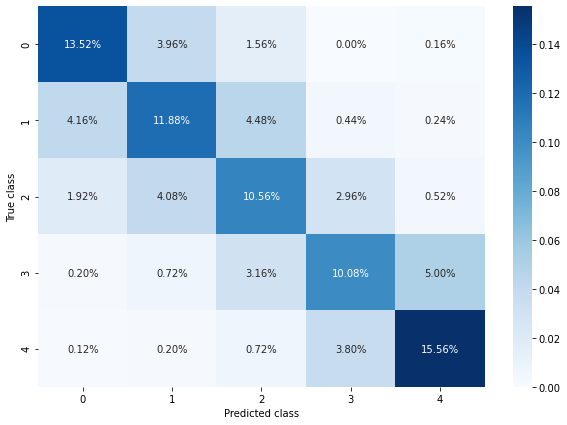

In [107]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
#ns.heatmap(matrix, annot=True)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.xlabel("Predicted class")
plt.ylabel("True class") 
plt.show()

In [108]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69       480
           1       0.57      0.56      0.57       530
           2       0.52      0.53      0.52       501
           3       0.58      0.53      0.55       479
           4       0.72      0.76      0.74       510

    accuracy                           0.62      2500
   macro avg       0.61      0.62      0.61      2500
weighted avg       0.61      0.62      0.61      2500



# Sweep PARAMETROS 

#### Sweep lstm

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [2, 5, 10]
        },
        'batch_size': {
            'values': [256, 128, 64, 32]
        },
        'dropout': {
            'values': [0.3, 0.4, 0.5]
        },
        'weight_decay': {
            'values': [0.0005, 0.005, 0.05]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        'optimizer': {
            'values': ['adam']
        },
        'activation': {
            'values': ['sigmoid', 'softmax']
        }
    }
}

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="lucialarraona", project="Sweepslucia")

Create sweep with ID: bd89jck9
Sweep URL: https://wandb.ai/lucialarraona/Sweepslucia/sweeps/bd89jck9


In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Embedding
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 5,
        'batch_size': 128,
        'weight_decay': 0.0005,
        'learning_rate': 1e-3,
        'activation': 'sigmoid',
        'optimizer': 'adam',
        'hidden_layer_size': 128,
        'dropout': 0.5,
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture 

    num_tokens = vocab_size 
    embedding_dim = 300 
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )
 
    model = Sequential()
    embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
    model.add(embed)
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(128,return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(5,activation='sigmoid'))

    # Define the optimizer
 
    if config.optimizer=='adam':
      optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

    model.fit(padded_rev, y_train_oh, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(padded_rev_val, y_val_oh),
              callbacks=[WandbCallback(validation_data=(padded_rev_val, y_val_oh))])

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: wa33nah6 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/5
3125/3125 [==============================] - 153s 46ms/step - loss: 1.6094 - accuracy: 0.2013 - val_loss: 1.6092 - val_accuracy: 0.2000
Epoch 2/5
3125/3125 [==============================] - 142s 46ms/step - loss: 1.6092 - accuracy: 0.2022 - val_loss: 1.6094 - val_accuracy: 0.1876
Epoch 3/5
3125/3125 [==============================] - 142s 45ms/step - loss: 1.6093 - accuracy: 0.1992 - val_loss: 1.6091 - val_accuracy: 0.2080
Epoch 4/5
3125/3125 [==============================] - 142s 45ms/step - loss: 1.6093 - accuracy: 0.2008 - val_loss: 1.6086 - val_accuracy: 0.2092
Epoch 5/5
3125/3125 [==============================] - 141s 45ms/step - loss: 1.6094 - accuracy: 0.2001 - val_loss: 1.6089 - val_accuracy: 0.1976


epoch,4
loss,1.60931
accuracy,0.19953
val_loss,1.60887
val_accuracy,0.1976
_runtime,725
_timestamp,1615130001
_step,4
best_val_loss,1.60858
best_epoch,3


epoch,▁▃▅▆█
loss,█▃▄▂▁
accuracy,▆█▃▁▂
val_loss,▆█▅▁▄
val_accuracy,▅▁██▄
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: yssx5p6c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5
1563/1563 [==============================] - 102s 62ms/step - loss: 1.6095 - accuracy: 0.2014 - val_loss: 1.6091 - val_accuracy: 0.1964
Epoch 2/5
1563/1563 [==============================] - 96s 62ms/step - loss: 1.6094 - accuracy: 0.2016 - val_loss: 1.6090 - val_accuracy: 0.2092
Epoch 3/5
1563/1563 [==============================] - 96s 61ms/step - loss: 1.6094 - accuracy: 0.1994 - val_loss: 1.6095 - val_accuracy: 0.1888
Epoch 4/5
1563/1563 [==============================] - 95s 61ms/step - loss: 1.6094 - accuracy: 0.2012 - val_loss: 1.6095 - val_accuracy: 0.1880
Epoch 5/5
1563/1563 [==============================] - 95s 61ms/step - loss: 1.6093 - accuracy: 0.2002 - val_loss: 1.6092 - val_accuracy: 0.2084


epoch,4
loss,1.6094
accuracy,0.19948
val_loss,1.60915
val_accuracy,0.2084
_runtime,487
_timestamp,1615130497
_step,4
best_val_loss,1.60899
best_epoch,1


epoch,▁▃▅▆█
loss,█▅▁▂▂
accuracy,█▄▁▇▁
val_loss,▂▁██▃
val_accuracy,▄█▁▁█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: c196erx3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
6250/6250 [==============================] - 234s 37ms/step - loss: 1.6094 - accuracy: 0.1994 - val_loss: 1.6089 - val_accuracy: 0.1976
Epoch 2/2
6250/6250 [==============================] - 230s 37ms/step - loss: 1.6094 - accuracy: 0.1996 - val_loss: 1.6090 - val_accuracy: 0.2100


epoch,1
loss,1.60931
accuracy,0.20032
val_loss,1.60897
val_accuracy,0.21
_runtime,468
_timestamp,1615130974
_step,1
best_val_loss,1.60891
best_epoch,0


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,▁█
val_accuracy,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: uxglldtx with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/5
3125/3125 [==============================] - 146s 46ms/step - loss: 1.6094 - accuracy: 0.1979 - val_loss: 1.6090 - val_accuracy: 0.1884
Epoch 2/5
3125/3125 [==============================] - 141s 45ms/step - loss: 1.6093 - accuracy: 0.1996 - val_loss: 1.6087 - val_accuracy: 0.2096
Epoch 3/5
3125/3125 [==============================] - 142s 45ms/step - loss: 1.6092 - accuracy: 0.2001 - val_loss: 1.6086 - val_accuracy: 0.1984
Epoch 4/5
3125/3125 [==============================] - 143s 46ms/step - loss: 1.5334 - accuracy: 0.2667 - val_loss: 1.3617 - val_accuracy: 0.3900
Epoch 5/5
3125/3125 [==============================] - 144s 46ms/step - loss: 1.3352 - accuracy: 0.3922 - val_loss: 1.3134 - val_accuracy: 0.4116


epoch,4
loss,1.32758
accuracy,0.39602
val_loss,1.31338
val_accuracy,0.4116
_runtime,720
_timestamp,1615131703
_step,4
best_val_loss,1.31338
best_epoch,4


epoch,▁▃▅▆█
loss,███▄▁
accuracy,▁▁▁▅█
val_loss,███▂▁
val_accuracy,▁▂▁▇█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: mq6pueih with config:
wandb: 	activation: softmax
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
782/782 [==============================] - 74s 88ms/step - loss: 1.6141 - accuracy: 0.1976 - val_loss: 1.6094 - val_accuracy: 0.2080
Epoch 2/2
782/782 [==============================] - 68s 87ms/step - loss: 1.6098 - accuracy: 0.2004 - val_loss: 1.6121 - val_accuracy: 0.1880


epoch,1
loss,1.60977
accuracy,0.20016
val_loss,1.61213
val_accuracy,0.188
_runtime,146
_timestamp,1615131858
_step,1
best_val_loss,1.60944
best_epoch,0


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,▁█
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: t5j4t9s3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
782/782 [==============================] - 73s 88ms/step - loss: 1.6094 - accuracy: 0.1992 - val_loss: 1.6094 - val_accuracy: 0.2004
Epoch 2/2
782/782 [==============================] - 68s 87ms/step - loss: 1.6094 - accuracy: 0.1997 - val_loss: 1.6093 - val_accuracy: 0.1976


epoch,1
loss,1.60938
accuracy,0.19847
val_loss,1.60928
val_accuracy,0.1976
_runtime,145
_timestamp,1615132012
_step,1
best_val_loss,1.60928
best_epoch,1


epoch,▁█
loss,█▁
accuracy,█▁
val_loss,█▁
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: be23lhch with config:
wandb: 	activation: softmax
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5
6250/6250 [==============================] - 241s 38ms/step - loss: 1.6121 - accuracy: 0.1991 - val_loss: 1.6098 - val_accuracy: 0.1972
Epoch 2/5
6250/6250 [==============================] - 242s 39ms/step - loss: 1.6099 - accuracy: 0.2032 - val_loss: 1.6096 - val_accuracy: 0.1880
Epoch 3/5
6250/6250 [==============================] - 247s 40ms/step - loss: 1.6096 - accuracy: 0.2003 - val_loss: 1.6099 - val_accuracy: 0.1880
Epoch 4/5
6250/6250 [==============================] - 248s 40ms/step - loss: 1.6096 - accuracy: 0.1983 - val_loss: 1.6093 - val_accuracy: 0.2084
Epoch 5/5
6250/6250 [==============================] - 248s 40ms/step - loss: 1.6096 - accuracy: 0.1997 - val_loss: 1.6097 - val_accuracy: 0.2080


epoch,4
loss,1.60956
accuracy,0.20021
val_loss,1.60965
val_accuracy,0.208
_runtime,1230
_timestamp,1615133251
_step,4
best_val_loss,1.60934
best_epoch,3


epoch,▁▃▅▆█
loss,█▃▁▁▁
accuracy,▃█▅▁▅
val_loss,▆▅█▁▅
val_accuracy,▄▁▁██
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: x83ybfaf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/5
3125/3125 [==============================] - 150s 47ms/step - loss: 1.6096 - accuracy: 0.2018 - val_loss: 1.6088 - val_accuracy: 0.2000
Epoch 2/5
3125/3125 [==============================] - 146s 47ms/step - loss: 1.6096 - accuracy: 0.1977 - val_loss: 1.6094 - val_accuracy: 0.1880
Epoch 3/5
3125/3125 [==============================] - 146s 47ms/step - loss: 1.6095 - accuracy: 0.1995 - val_loss: 1.6090 - val_accuracy: 0.2080
Epoch 4/5
3125/3125 [==============================] - 146s 47ms/step - loss: 1.6093 - accuracy: 0.2020 - val_loss: 1.6091 - val_accuracy: 0.1888
Epoch 5/5
3125/3125 [==============================] - 146s 47ms/step - loss: 1.6093 - accuracy: 0.2019 - val_loss: 1.6080 - val_accuracy: 0.2084


epoch,4
loss,1.60937
accuracy,0.20226
val_loss,1.60796
val_accuracy,0.2084
_runtime,737
_timestamp,1615133997
_step,4
best_val_loss,1.60796
best_epoch,4


epoch,▁▃▅▆█
loss,█▆▃▁▁
accuracy,▃▁▄▇█
val_loss,▅█▆▇▁
val_accuracy,▅▁█▁█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: w0kc0jjq with config:
wandb: 	activation: softmax
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
6250/6250 [==============================] - 254s 40ms/step - loss: 1.6183 - accuracy: 0.2008 - val_loss: 1.6124 - val_accuracy: 0.1996
Epoch 2/2
6250/6250 [==============================] - 250s 40ms/step - loss: 1.6167 - accuracy: 0.2012 - val_loss: 1.6120 - val_accuracy: 0.1996


epoch,1
loss,1.6138
accuracy,0.20023
val_loss,1.61201
val_accuracy,0.1996
_runtime,508
_timestamp,1615134514
_step,1
best_val_loss,1.61201
best_epoch,1


epoch,▁█
loss,▁█
accuracy,█▁
val_loss,█▁
val_accuracy,▁▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: jx34wknp with config:
wandb: 	activation: softmax
wandb: 	batch_size: 256
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5
782/782 [==============================] - 74s 89ms/step - loss: 1.6094 - accuracy: 0.1991 - val_loss: 1.6093 - val_accuracy: 0.2004
Epoch 2/5
782/782 [==============================] - 69s 88ms/step - loss: 1.6094 - accuracy: 0.2000 - val_loss: 1.6092 - val_accuracy: 0.1980
Epoch 3/5
782/782 [==============================] - 69s 88ms/step - loss: 1.6093 - accuracy: 0.1995 - val_loss: 1.6089 - val_accuracy: 0.1980
Epoch 4/5
782/782 [==============================] - 69s 88ms/step - loss: 1.6093 - accuracy: 0.1989 - val_loss: 1.6088 - val_accuracy: 0.1980
Epoch 5/5
782/782 [==============================] - 68s 88ms/step - loss: 1.6092 - accuracy: 0.2029 - val_loss: 1.6087 - val_accuracy: 0.2084


epoch,4
loss,1.60922
accuracy,0.20099
val_loss,1.60872
val_accuracy,0.2084
_runtime,354
_timestamp,1615134877
_step,4
best_val_loss,1.60872
best_epoch,4


epoch,▁▃▅▆█
loss,█▆▄▂▁
accuracy,▂▃▂▁█
val_loss,█▆▃▂▁
val_accuracy,▃▁▁▁█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: rvbmwwye with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
3125/3125 [==============================] - 155s 48ms/step - loss: 1.6094 - accuracy: 0.1981 - val_loss: 1.6090 - val_accuracy: 0.1980
Epoch 2/2
3125/3125 [==============================] - 150s 48ms/step - loss: 1.6093 - accuracy: 0.2000 - val_loss: 1.6089 - val_accuracy: 0.1980


epoch,1
loss,1.6093
accuracy,0.19942
val_loss,1.60891
val_accuracy,0.198
_runtime,309
_timestamp,1615135197
_step,1
best_val_loss,1.60891
best_epoch,1


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,█▁
val_accuracy,▁▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: f815v52x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/2
1563/1563 [==============================] - 106s 65ms/step - loss: 1.6121 - accuracy: 0.2018 - val_loss: 1.6073 - val_accuracy: 0.2012
Epoch 2/2
1563/1563 [==============================] - 100s 64ms/step - loss: 1.6088 - accuracy: 0.2050 - val_loss: 1.6084 - val_accuracy: 0.1880


epoch,1
loss,1.60864
accuracy,0.20434
val_loss,1.60842
val_accuracy,0.188
_runtime,211
_timestamp,1615135418
_step,1
best_val_loss,1.6073
best_epoch,0


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,▁█
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: 0sktxcl3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5
6250/6250 [==============================] - 244s 38ms/step - loss: 1.6102 - accuracy: 0.2000 - val_loss: 1.6097 - val_accuracy: 0.1964
Epoch 2/5
6250/6250 [==============================] - 240s 38ms/step - loss: 1.6098 - accuracy: 0.1999 - val_loss: 1.6093 - val_accuracy: 0.1980
Epoch 3/5
6250/6250 [==============================] - 240s 38ms/step - loss: 1.6095 - accuracy: 0.2004 - val_loss: 1.6093 - val_accuracy: 0.2088
Epoch 4/5
6250/6250 [==============================] - 242s 39ms/step - loss: 1.6096 - accuracy: 0.2006 - val_loss: 1.6089 - val_accuracy: 0.1996
Epoch 5/5
6250/6250 [==============================] - 243s 39ms/step - loss: 1.6095 - accuracy: 0.2002 - val_loss: 1.6095 - val_accuracy: 0.2084


epoch,4
loss,1.60949
accuracy,0.20017
val_loss,1.6095
val_accuracy,0.2084
_runtime,1214
_timestamp,1615136641
_step,4
best_val_loss,1.60895
best_epoch,3


epoch,▁▃▅▆█
loss,█▅▂▁▁
accuracy,▁▅▂▃█
val_loss,█▄▄▁▆
val_accuracy,▁▂█▃█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: ws8x3ucz with config:
wandb: 	activation: softmax
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/5
6250/6250 [==============================] - 244s 38ms/step - loss: 1.6094 - accuracy: 0.1999 - val_loss: 1.6089 - val_accuracy: 0.2084
Epoch 2/5
6250/6250 [==============================] - 239s 38ms/step - loss: 1.6093 - accuracy: 0.2010 - val_loss: 1.6090 - val_accuracy: 0.1984
Epoch 3/5
6250/6250 [==============================] - 239s 38ms/step - loss: 1.5214 - accuracy: 0.2690 - val_loss: 1.3422 - val_accuracy: 0.4108
Epoch 4/5
6250/6250 [==============================] - 239s 38ms/step - loss: 1.3315 - accuracy: 0.3951 - val_loss: 1.3336 - val_accuracy: 0.3884
Epoch 5/5
6250/6250 [==============================] - 241s 39ms/step - loss: 1.3046 - accuracy: 0.4101 - val_loss: 1.2866 - val_accuracy: 0.4288


epoch,4
loss,1.29931
accuracy,0.41379
val_loss,1.2866
val_accuracy,0.4288
_runtime,1206
_timestamp,1615137856
_step,4
best_val_loss,1.2866
best_epoch,4


epoch,▁▃▅▆█
loss,██▄▂▁
accuracy,▁▁▅▇█
val_loss,██▂▂▁
val_accuracy,▁▁▇▇█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: xenuglk0 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/5
782/782 [==============================] - 75s 90ms/step - loss: 1.6097 - accuracy: 0.2000 - val_loss: 1.6097 - val_accuracy: 0.1968
Epoch 2/5
782/782 [==============================] - 69s 88ms/step - loss: 1.6096 - accuracy: 0.1996 - val_loss: 1.6091 - val_accuracy: 0.1968
Epoch 3/5
782/782 [==============================] - 69s 88ms/step - loss: 1.6095 - accuracy: 0.1999 - val_loss: 1.6091 - val_accuracy: 0.1996
Epoch 4/5
782/782 [==============================] - 69s 89ms/step - loss: 1.6095 - accuracy: 0.1980 - val_loss: 1.6093 - val_accuracy: 0.1968
Epoch 5/5
782/782 [==============================] - 69s 89ms/step - loss: 1.6095 - accuracy: 0.2017 - val_loss: 1.6094 - val_accuracy: 0.1880


epoch,4
loss,1.60947
accuracy,0.20152
val_loss,1.60942
val_accuracy,0.188
_runtime,356
_timestamp,1615138221
_step,4
best_val_loss,1.60905
best_epoch,2


epoch,▁▃▅▆█
loss,█▅▂▁▂
accuracy,▃▂▁▁█
val_loss,█▁▁▄▅
val_accuracy,▆▆█▆▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: g05wmq07 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/10
782/782 [==============================] - 75s 90ms/step - loss: 1.6095 - accuracy: 0.1998 - val_loss: 1.6091 - val_accuracy: 0.2092
Epoch 2/10
782/782 [==============================] - 69s 89ms/step - loss: 1.6094 - accuracy: 0.2002 - val_loss: 1.6087 - val_accuracy: 0.2092
Epoch 3/10
782/782 [==============================] - 69s 89ms/step - loss: 1.6094 - accuracy: 0.2016 - val_loss: 1.6092 - val_accuracy: 0.2092
Epoch 4/10
782/782 [==============================] - 69s 88ms/step - loss: 1.6093 - accuracy: 0.2004 - val_loss: 1.6094 - val_accuracy: 0.1888
Epoch 5/10
782/782 [==============================] - 69s 89ms/step - loss: 1.6093 - accuracy: 0.2008 - val_loss: 1.6091 - val_accuracy: 0.2088
Epoch 6/10
782/782 [==============================] - 69s 89ms/step - loss: 1.6092 - accuracy: 0.2014 - val_loss: 1.6092 - val_accuracy: 0.2092
Epoch 7/10
782/782 [==============================] - 70s 89ms/step - loss: 1.6092 - accuracy: 0.2019 - val_loss: 1.6094 - val_accuracy:

epoch,9
loss,1.60912
accuracy,0.1991
val_loss,1.60894
val_accuracy,0.1876
_runtime,704
_timestamp,1615138934
_step,9
best_val_loss,1.6087
best_epoch,1


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▆▅▅▅▄▃█▁
accuracy,▄▄▆▅██▆▆▂▁
val_loss,▅▁▅█▄▆▇▁▃▃
val_accuracy,███▁██▄▅▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: lh6uz1yg with config:
wandb: 	activation: softmax
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
6250/6250 [==============================] - 258s 41ms/step - loss: 1.6139 - accuracy: 0.2011 - val_loss: 1.6098 - val_accuracy: 0.1960
Epoch 2/2
6250/6250 [==============================] - 254s 41ms/step - loss: 1.6106 - accuracy: 0.1982 - val_loss: 1.6104 - val_accuracy: 0.1880


epoch,1
loss,1.61098
accuracy,0.19949
val_loss,1.61043
val_accuracy,0.188
_runtime,517
_timestamp,1615139459
_step,1
best_val_loss,1.60977
best_epoch,0


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,▁█
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: riom5fnt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/2
1563/1563 [==============================] - 111s 68ms/step - loss: 1.6094 - accuracy: 0.1995 - val_loss: 1.6093 - val_accuracy: 0.2084
Epoch 2/2
1563/1563 [==============================] - 106s 68ms/step - loss: 1.6093 - accuracy: 0.1988 - val_loss: 1.6089 - val_accuracy: 0.1996


epoch,1
loss,1.6093
accuracy,0.19945
val_loss,1.60891
val_accuracy,0.1996
_runtime,221
_timestamp,1615139689
_step,1
best_val_loss,1.60891
best_epoch,1


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,█▁
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: ev68x1sy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/10
1563/1563 [==============================] - 109s 67ms/step - loss: 1.6096 - accuracy: 0.1989 - val_loss: 1.6097 - val_accuracy: 0.1964
Epoch 2/10
1563/1563 [==============================] - 104s 66ms/step - loss: 1.6094 - accuracy: 0.2007 - val_loss: 1.6092 - val_accuracy: 0.1964
Epoch 3/10
1563/1563 [==============================] - 104s 66ms/step - loss: 1.6094 - accuracy: 0.2009 - val_loss: 1.6091 - val_accuracy: 0.2000
Epoch 4/10
1563/1563 [==============================] - 104s 66ms/step - loss: 1.6095 - accuracy: 0.1999 - val_loss: 1.6094 - val_accuracy: 0.1884
Epoch 5/10
1563/1563 [==============================] - 103s 66ms/step - loss: 1.6093 - accuracy: 0.1998 - val_loss: 1.6091 - val_accuracy: 0.1976
Epoch 6/10
1563/1563 [==============================] - 103s 66ms/step - loss: 1.6093 - accuracy: 0.2005 - val_loss: 1.6094 - val_accuracy: 0.1968
Epoch 7/10
1563/1563 [==============================] - 103s 66ms/step - loss: 1.6094 - accuracy: 0.1985 - val_loss: 1

epoch,9
loss,1.60904
accuracy,0.20022
val_loss,1.60918
val_accuracy,0.1884
_runtime,1040
_timestamp,1615140739
_step,9
best_val_loss,1.60801
best_epoch,7


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▆▇▅▅▃▄▁
accuracy,▃▅█▆▇▅▂▂▁▅
val_loss,█▆▅▇▅▇▄▁▄▆
val_accuracy,▄▄▅▁▄▄▅▄█▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 5r35pzlh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/10
782/782 [==============================] - 74s 89ms/step - loss: 1.6134 - accuracy: 0.1999 - val_loss: 1.6096 - val_accuracy: 0.2080
Epoch 2/10
782/782 [==============================] - 69s 88ms/step - loss: 1.6098 - accuracy: 0.2005 - val_loss: 1.6095 - val_accuracy: 0.1880
Epoch 3/10
782/782 [==============================] - 69s 88ms/step - loss: 1.6097 - accuracy: 0.1999 - val_loss: 1.6093 - val_accuracy: 0.2080
Epoch 4/10
782/782 [==============================] - 68s 88ms/step - loss: 1.6098 - accuracy: 0.2012 - val_loss: 1.6100 - val_accuracy: 0.1880
Epoch 5/10
782/782 [==============================] - 68s 87ms/step - loss: 1.6098 - accuracy: 0.1997 - val_loss: 1.6090 - val_accuracy: 0.2080
Epoch 6/10
782/782 [==============================] - 69s 88ms/step - loss: 1.6098 - accuracy: 0.2004 - val_loss: 1.6090 - val_accuracy: 0.1996
Epoch 7/10
782/782 [==============================] - 68s 87ms/step - loss: 1.6097 - accuracy: 0.2006 - val_loss: 1.6096 - val_accuracy:

epoch,9
loss,1.60972
accuracy,0.20063
val_loss,1.61038
val_accuracy,0.188
_runtime,695
_timestamp,1615141443
_step,9
best_val_loss,1.60886
best_epoch,7


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
accuracy,▂▄▄▄▁▄▆▃█▆
val_loss,▃▃▃▅▂▂▃▁█▆
val_accuracy,█▁█▁█▅▅█▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ik42ibr2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/10
782/782 [==============================] - 74s 90ms/step - loss: 1.6094 - accuracy: 0.1992 - val_loss: 1.6089 - val_accuracy: 0.2000
Epoch 2/10
782/782 [==============================] - 69s 88ms/step - loss: 1.6092 - accuracy: 0.1992 - val_loss: 1.6088 - val_accuracy: 0.2084
Epoch 3/10
782/782 [==============================] - 69s 88ms/step - loss: 1.6092 - accuracy: 0.2026 - val_loss: 1.6088 - val_accuracy: 0.2100
Epoch 4/10
782/782 [==============================] - 69s 89ms/step - loss: 1.6092 - accuracy: 0.1999 - val_loss: 1.6085 - val_accuracy: 0.1980
Epoch 5/10
782/782 [==============================] - 69s 89ms/step - loss: 1.5589 - accuracy: 0.2455 - val_loss: 1.3847 - val_accuracy: 0.3612
Epoch 6/10
782/782 [==============================] - 70s 89ms/step - loss: 1.3620 - accuracy: 0.3671 - val_loss: 1.3423 - val_accuracy: 0.4084
Epoch 7/10
782/782 [==============================] - 69s 89ms/step - loss: 1.3239 - accuracy: 0.3965 - val_loss: 1.3187 - val_accuracy:

epoch,9
loss,1.2956
accuracy,0.41192
val_loss,1.29318
val_accuracy,0.4196
_runtime,702
_timestamp,1615142153
_step,9
best_val_loss,1.29318
best_epoch,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,████▅▂▂▁▁▁
accuracy,▁▁▁▁▄▇████
val_loss,████▃▂▂▁▁▁
val_accuracy,▁▁▁▁▆█████
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: rkbqxqxz with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/2
3125/3125 [==============================] - 164s 51ms/step - loss: 1.6119 - accuracy: 0.2049 - val_loss: 1.6101 - val_accuracy: 0.1880
Epoch 2/2
3125/3125 [==============================] - 161s 52ms/step - loss: 1.6101 - accuracy: 0.1983 - val_loss: 1.6109 - val_accuracy: 0.1880


epoch,1
loss,1.61005
accuracy,0.19938
val_loss,1.61087
val_accuracy,0.188
_runtime,329
_timestamp,1615142491
_step,1
best_val_loss,1.6101
best_epoch,0


epoch,▁█
loss,█▁
accuracy,█▁
val_loss,▁█
val_accuracy,▁▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: ug93x2uv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/5
6250/6250 [==============================] - 262s 41ms/step - loss: 1.6153 - accuracy: 0.2006 - val_loss: 1.6104 - val_accuracy: 0.1960
Epoch 2/5
6250/6250 [==============================] - 258s 41ms/step - loss: 1.6142 - accuracy: 0.2032 - val_loss: 1.6157 - val_accuracy: 0.2084
Epoch 3/5
6250/6250 [==============================] - 258s 41ms/step - loss: 1.6213 - accuracy: 0.1999 - val_loss: 1.6225 - val_accuracy: 0.1960
Epoch 4/5
6250/6250 [==============================] - 258s 41ms/step - loss: 1.6202 - accuracy: 0.2020 - val_loss: 1.6110 - val_accuracy: 0.2080
Epoch 5/5
6250/6250 [==============================] - 257s 41ms/step - loss: 1.6198 - accuracy: 0.2008 - val_loss: 1.6054 - val_accuracy: 0.2172


epoch,4
loss,1.61857
accuracy,0.20095
val_loss,1.60543
val_accuracy,0.2172
_runtime,1298
_timestamp,1615143798
_step,4
best_val_loss,1.60543
best_epoch,4


epoch,▁▃▅▆█
loss,▁▇██▆
accuracy,▂█▄▁▃
val_loss,▃▅█▃▁
val_accuracy,▁▅▁▅█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: n7rb0xu2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
1563/1563 [==============================] - 113s 69ms/step - loss: 1.6094 - accuracy: 0.2004 - val_loss: 1.6093 - val_accuracy: 0.1888
Epoch 2/2
1563/1563 [==============================] - 107s 69ms/step - loss: 1.6093 - accuracy: 0.1977 - val_loss: 1.6089 - val_accuracy: 0.2096


epoch,1
loss,1.60929
accuracy,0.1982
val_loss,1.60888
val_accuracy,0.2096
_runtime,225
_timestamp,1615144032
_step,1
best_val_loss,1.60888
best_epoch,1


epoch,▁█
loss,█▁
accuracy,█▁
val_loss,█▁
val_accuracy,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: o7aghs6l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/2
3125/3125 [==============================] - 163s 51ms/step - loss: 1.6096 - accuracy: 0.2007 - val_loss: 1.6099 - val_accuracy: 0.1968
Epoch 2/2
3125/3125 [==============================] - 159s 51ms/step - loss: 1.6095 - accuracy: 0.2015 - val_loss: 1.6089 - val_accuracy: 0.1996


epoch,1
loss,1.60948
accuracy,0.20072
val_loss,1.60887
val_accuracy,0.1996
_runtime,326
_timestamp,1615144367
_step,1
best_val_loss,1.60887
best_epoch,1


epoch,▁█
loss,█▁
accuracy,█▁
val_loss,█▁
val_accuracy,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: aj62swuz with config:
wandb: 	activation: softmax
wandb: 	batch_size: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/10
782/782 [==============================] - 77s 92ms/step - loss: 1.6160 - accuracy: 0.1996 - val_loss: 1.6099 - val_accuracy: 0.1880
Epoch 2/10
782/782 [==============================] - 71s 91ms/step - loss: 1.6098 - accuracy: 0.1993 - val_loss: 1.6095 - val_accuracy: 0.1960
Epoch 3/10
782/782 [==============================] - 71s 90ms/step - loss: 1.6097 - accuracy: 0.1991 - val_loss: 1.6096 - val_accuracy: 0.2080
Epoch 4/10
782/782 [==============================] - 71s 90ms/step - loss: 1.6098 - accuracy: 0.1993 - val_loss: 1.6105 - val_accuracy: 0.1996
Epoch 5/10
782/782 [==============================] - 70s 90ms/step - loss: 1.6098 - accuracy: 0.1994 - val_loss: 1.6095 - val_accuracy: 0.2080
Epoch 6/10
782/782 [==============================] - 71s 90ms/step - loss: 1.6097 - accuracy: 0.2001 - val_loss: 1.6106 - val_accuracy: 0.1996
Epoch 7/10
782/782 [==============================] - 70s 90ms/step - loss: 1.6097 - accuracy: 0.1981 - val_loss: 1.6097 - val_accuracy:

epoch,9
loss,1.60979
accuracy,0.19967
val_loss,1.61004
val_accuracy,0.188
_runtime,716
_timestamp,1615145092
_step,9
best_val_loss,1.60946
best_epoch,1


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
accuracy,▆▃▅▆█▅▁▇█▆
val_loss,▄▁▂▇▁█▃▄▅▅
val_accuracy,▁▄█▅█▅█▅▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 0zlid2vd with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/10
1563/1563 [==============================] - 111s 68ms/step - loss: 1.6094 - accuracy: 0.2008 - val_loss: 1.6091 - val_accuracy: 0.2084
Epoch 2/10
1563/1563 [==============================] - 106s 68ms/step - loss: 1.6094 - accuracy: 0.1988 - val_loss: 1.6085 - val_accuracy: 0.2084
Epoch 3/10
1563/1563 [==============================] - 105s 67ms/step - loss: 1.6094 - accuracy: 0.2011 - val_loss: 1.6090 - val_accuracy: 0.2076
Epoch 4/10
1563/1563 [==============================] - 105s 67ms/step - loss: 1.6094 - accuracy: 0.1976 - val_loss: 1.6091 - val_accuracy: 0.1976
Epoch 5/10
1563/1563 [==============================] - 105s 67ms/step - loss: 1.6093 - accuracy: 0.1978 - val_loss: 1.6088 - val_accuracy: 0.2092
Epoch 6/10
1563/1563 [==============================] - 105s 67ms/step - loss: 1.6093 - accuracy: 0.2014 - val_loss: 1.6091 - val_accuracy: 0.1876
Epoch 7/10
1563/1563 [==============================] - 105s 67ms/step - loss: 1.6093 - accuracy: 0.1997 - val_loss: 1

epoch,9
loss,1.60905
accuracy,0.2017
val_loss,1.60837
val_accuracy,0.2084
_runtime,1060
_timestamp,1615146163
_step,9
best_val_loss,1.60837
best_epoch,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▇▆▆▅▄▂▁
accuracy,▆▁▄▂▂▃▄▄▁█
val_loss,▇▂▇█▅█▇▆▄▁
val_accuracy,██▇▄█▁▇█▂█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: a0ibo6r2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/2
6250/6250 [==============================] - 249s 39ms/step - loss: 1.6094 - accuracy: 0.2006 - val_loss: 1.6089 - val_accuracy: 0.2084
Epoch 2/2
6250/6250 [==============================] - 245s 39ms/step - loss: 1.6093 - accuracy: 0.2012 - val_loss: 1.6086 - val_accuracy: 0.2092


epoch,1
loss,1.60923
accuracy,0.20083
val_loss,1.60857
val_accuracy,0.2092
_runtime,499
_timestamp,1615146673
_step,1
best_val_loss,1.60857
best_epoch,1


epoch,▁█
loss,█▁
accuracy,█▁
val_loss,█▁
val_accuracy,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: szuajpkh with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/10
3125/3125 [==============================] - 171s 54ms/step - loss: 1.6150 - accuracy: 0.1998 - val_loss: 1.6108 - val_accuracy: 0.1960
Epoch 2/10
3125/3125 [==============================] - 164s 53ms/step - loss: 1.6101 - accuracy: 0.2020 - val_loss: 1.6095 - val_accuracy: 0.1960
Epoch 3/10
3125/3125 [==============================] - 163s 52ms/step - loss: 1.6100 - accuracy: 0.1994 - val_loss: 1.6103 - val_accuracy: 0.2080
Epoch 4/10
3125/3125 [==============================] - 162s 52ms/step - loss: 1.6100 - accuracy: 0.2002 - val_loss: 1.6100 - val_accuracy: 0.1996
Epoch 5/10
3125/3125 [==============================] - 161s 52ms/step - loss: 1.6101 - accuracy: 0.1993 - val_loss: 1.6095 - val_accuracy: 0.2080
Epoch 6/10
3125/3125 [==============================] - 162s 52ms/step - loss: 1.6100 - accuracy: 0.2018 - val_loss: 1.6092 - val_accuracy: 0.2084
Epoch 7/10
3125/3125 [==============================] - 162s 52ms/step - loss: 1.6101 - accuracy: 0.1994 - val_loss: 1

epoch,9
loss,1.61009
accuracy,0.19922
val_loss,1.60963
val_accuracy,0.188
_runtime,1626
_timestamp,1615148308
_step,9
best_val_loss,1.60917
best_epoch,5


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▂▁
accuracy,▁▅▂▄███▄▄▁
val_loss,▇▂▅▄▂▁▄▆█▃
val_accuracy,▄▄█▅██▅▅▄▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: rhleehe3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/10
1563/1563 [==============================] - 111s 68ms/step - loss: 1.6166 - accuracy: 0.2011 - val_loss: 1.6093 - val_accuracy: 0.1996
Epoch 2/10
1563/1563 [==============================] - 105s 67ms/step - loss: 1.6099 - accuracy: 0.2019 - val_loss: 1.6090 - val_accuracy: 0.2080
Epoch 3/10
1563/1563 [==============================] - 105s 67ms/step - loss: 1.6099 - accuracy: 0.1998 - val_loss: 1.6099 - val_accuracy: 0.1960
Epoch 4/10
1563/1563 [==============================] - 104s 67ms/step - loss: 1.6099 - accuracy: 0.2008 - val_loss: 1.6096 - val_accuracy: 0.1880
Epoch 5/10
1563/1563 [==============================] - 105s 67ms/step - loss: 1.6098 - accuracy: 0.2021 - val_loss: 1.6102 - val_accuracy: 0.1880
Epoch 6/10
1563/1563 [==============================] - 108s 69ms/step - loss: 1.6100 - accuracy: 0.2002 - val_loss: 1.6103 - val_accuracy: 0.1880
Epoch 7/10
1563/1563 [==============================] - 106s 68ms/step - loss: 1.6099 - accuracy: 0.1991 - val_loss: 1

epoch,9
loss,1.60999
accuracy,0.19951
val_loss,1.61031
val_accuracy,0.196
_runtime,1063
_timestamp,1615149382
_step,9
best_val_loss,1.60904
best_epoch,1


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▂▁▁▁▂
accuracy,▄▄▃▅█▃▂▁▂▂
val_loss,▂▁▅▄▇▇▃█▄▇
val_accuracy,▅█▄▁▁▁██▄▄
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ujc7c34e with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5
1563/1563 [==============================] - 109s 67ms/step - loss: 1.6094 - accuracy: 0.2004 - val_loss: 1.6089 - val_accuracy: 0.1988
Epoch 2/5
1563/1563 [==============================] - 103s 66ms/step - loss: 1.6092 - accuracy: 0.2005 - val_loss: 1.6089 - val_accuracy: 0.1988
Epoch 3/5
1563/1563 [==============================] - 104s 66ms/step - loss: 1.6092 - accuracy: 0.1995 - val_loss: 1.4951 - val_accuracy: 0.3060
Epoch 4/5
1563/1563 [==============================] - 105s 67ms/step - loss: 1.4165 - accuracy: 0.3404 - val_loss: 1.3423 - val_accuracy: 0.3892
Epoch 5/5
1563/1563 [==============================] - 105s 67ms/step - loss: 1.3288 - accuracy: 0.3919 - val_loss: 1.3179 - val_accuracy: 0.4132


epoch,4
loss,1.32438
accuracy,0.39535
val_loss,1.31792
val_accuracy,0.4132
_runtime,530
_timestamp,1615149923
_step,4
best_val_loss,1.31792
best_epoch,4


epoch,▁▃▅▆█
loss,███▂▁
accuracy,▁▁▁▇█
val_loss,██▅▂▁
val_accuracy,▁▁▄▇█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 26k3jlkr with config:
wandb: 	activation: softmax
wandb: 	batch_size: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/2
782/782 [==============================] - 77s 93ms/step - loss: 1.6094 - accuracy: 0.1999 - val_loss: 1.6088 - val_accuracy: 0.1880
Epoch 2/2
782/782 [==============================] - 71s 91ms/step - loss: 1.6004 - accuracy: 0.2080 - val_loss: 1.4047 - val_accuracy: 0.3488


epoch,1
loss,1.55563
accuracy,0.24382
val_loss,1.40472
val_accuracy,0.3488
_runtime,153
_timestamp,1615150087
_step,1
best_val_loss,1.40472
best_epoch,1


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,█▁
val_accuracy,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: emvyred3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/2
3125/3125 [==============================] - 167s 52ms/step - loss: 1.6095 - accuracy: 0.2014 - val_loss: 1.6095 - val_accuracy: 0.1968
Epoch 2/2
3125/3125 [==============================] - 162s 52ms/step - loss: 1.6096 - accuracy: 0.1996 - val_loss: 1.6090 - val_accuracy: 0.1996


epoch,1
loss,1.60954
accuracy,0.19858
val_loss,1.60898
val_accuracy,0.1996
_runtime,334
_timestamp,1615150430
_step,1
best_val_loss,1.60898
best_epoch,1


epoch,▁█
loss,▁█
accuracy,█▁
val_loss,█▁
val_accuracy,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: 8e87jp0r with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/2
1563/1563 [==============================] - 115s 70ms/step - loss: 1.6094 - accuracy: 0.1994 - val_loss: 1.6093 - val_accuracy: 0.2096
Epoch 2/2
1563/1563 [==============================] - 109s 70ms/step - loss: 1.6093 - accuracy: 0.2010 - val_loss: 1.6090 - val_accuracy: 0.2096


epoch,1
loss,1.6093
accuracy,0.2005
val_loss,1.60903
val_accuracy,0.2096
_runtime,228
_timestamp,1615150669
_step,1
best_val_loss,1.60903
best_epoch,1


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,█▁
val_accuracy,▁▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: t8oozodw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
3125/3125 [==============================] - 166s 52ms/step - loss: 1.6094 - accuracy: 0.2009 - val_loss: 1.6086 - val_accuracy: 0.2096
Epoch 2/2
3125/3125 [==============================] - 162s 52ms/step - loss: 1.6093 - accuracy: 0.2012 - val_loss: 1.6084 - val_accuracy: 0.1892


epoch,1
loss,1.60928
accuracy,0.19985
val_loss,1.60841
val_accuracy,0.1892
_runtime,332
_timestamp,1615151010
_step,1
best_val_loss,1.60841
best_epoch,1


epoch,▁█
loss,█▁
accuracy,█▁
val_loss,█▁
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: v5svchfg with config:
wandb: 	activation: softmax
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
6250/6250 [==============================] - 255s 40ms/step - loss: 1.6101 - accuracy: 0.2005 - val_loss: 1.6092 - val_accuracy: 0.2080
Epoch 2/2
6250/6250 [==============================] - 251s 40ms/step - loss: 1.6097 - accuracy: 0.2014 - val_loss: 1.6091 - val_accuracy: 0.1996


epoch,1
loss,1.60971
accuracy,0.20008
val_loss,1.60912
val_accuracy,0.1996
_runtime,511
_timestamp,1615151530
_step,1
best_val_loss,1.60912
best_epoch,1


epoch,▁█
loss,█▁
accuracy,█▁
val_loss,█▁
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: h9t0f3fy with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
3125/3125 [==============================] - 167s 52ms/step - loss: 1.6094 - accuracy: 0.2005 - val_loss: 1.6092 - val_accuracy: 0.2084
Epoch 2/2
3125/3125 [==============================] - 160s 51ms/step - loss: 1.6093 - accuracy: 0.2015 - val_loss: 1.6089 - val_accuracy: 0.1980


epoch,1
loss,1.60929
accuracy,0.20038
val_loss,1.60888
val_accuracy,0.198
_runtime,332
_timestamp,1615151871
_step,1
best_val_loss,1.60888
best_epoch,1


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,█▁
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: vsaekc0z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/5
1563/1563 [==============================] - 115s 70ms/step - loss: 1.6126 - accuracy: 0.1998 - val_loss: 1.6095 - val_accuracy: 0.2084
Epoch 2/5
1563/1563 [==============================] - 109s 70ms/step - loss: 1.6101 - accuracy: 0.2027 - val_loss: 1.6096 - val_accuracy: 0.1880
Epoch 3/5
1563/1563 [==============================] - 109s 70ms/step - loss: 1.6098 - accuracy: 0.2018 - val_loss: 1.6097 - val_accuracy: 0.1996
Epoch 4/5
1563/1563 [==============================] - 109s 70ms/step - loss: 1.6099 - accuracy: 0.2015 - val_loss: 1.6092 - val_accuracy: 0.2080
Epoch 5/5
1563/1563 [==============================] - 109s 70ms/step - loss: 1.6098 - accuracy: 0.1990 - val_loss: 1.6094 - val_accuracy: 0.1960


epoch,4
loss,1.60983
accuracy,0.20019
val_loss,1.60936
val_accuracy,0.196
_runtime,557
_timestamp,1615152439
_step,4
best_val_loss,1.60921
best_epoch,3


epoch,▁▃▅▆█
loss,█▃▂▂▁
accuracy,▁▄█▁▂
val_loss,▆▆█▁▃
val_accuracy,█▁▅█▄
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 9k8lz4po with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/5
3125/3125 [==============================] - 168s 52ms/step - loss: 1.6094 - accuracy: 0.1976 - val_loss: 1.6087 - val_accuracy: 0.2084
Epoch 2/5
3125/3125 [==============================] - 162s 52ms/step - loss: 1.6093 - accuracy: 0.2014 - val_loss: 1.6087 - val_accuracy: 0.1984
Epoch 3/5
3125/3125 [==============================] - 163s 52ms/step - loss: 1.6092 - accuracy: 0.2013 - val_loss: 1.6082 - val_accuracy: 0.2080
Epoch 4/5
3125/3125 [==============================] - 163s 52ms/step - loss: 1.5691 - accuracy: 0.2354 - val_loss: 1.3695 - val_accuracy: 0.3868
Epoch 5/5
3125/3125 [==============================] - 164s 52ms/step - loss: 1.3483 - accuracy: 0.3818 - val_loss: 1.3206 - val_accuracy: 0.4048


epoch,4
loss,1.33819
accuracy,0.3887
val_loss,1.32065
val_accuracy,0.4048
_runtime,825
_timestamp,1615153273
_step,4
best_val_loss,1.32065
best_epoch,4


epoch,▁▃▅▆█
loss,███▅▁
accuracy,▁▁▁▄█
val_loss,███▂▁
val_accuracy,▁▁▁▇█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Sweep Agent: Waiting for job.
502 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>

wandb: Job received.
wandb: Agent Starting Run: 3lrnwx6v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 2
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
3125/3125 [==============================] - 172s 54ms/step - loss: 1.6094 - accuracy: 0.1991 - val_loss: 1.6092 - val_accuracy: 0.2084
Epoch 2/2
3125/3125 [==============================] - 168s 54ms/step - loss: 1.6094 - accuracy: 0.1997 - val_loss: 1.6094 - val_accuracy: 0.1968


epoch,1
loss,1.60938
accuracy,0.19995
val_loss,1.60941
val_accuracy,0.1968
_runtime,345
_timestamp,1615153667
_step,1
best_val_loss,1.60917
best_epoch,0


epoch,▁█
loss,█▁
accuracy,█▁
val_loss,▁█
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: ogzfmqwg with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/5
3125/3125 [==============================] - 173s 54ms/step - loss: 1.6094 - accuracy: 0.1979 - val_loss: 1.6092 - val_accuracy: 0.1888
Epoch 2/5
3125/3125 [==============================] - 167s 53ms/step - loss: 1.6093 - accuracy: 0.1971 - val_loss: 1.6088 - val_accuracy: 0.2096
Epoch 3/5
3125/3125 [==============================] - 167s 54ms/step - loss: 1.6092 - accuracy: 0.2021 - val_loss: 1.6088 - val_accuracy: 0.1888
Epoch 4/5
3125/3125 [==============================] - 168s 54ms/step - loss: 1.6091 - accuracy: 0.1996 - val_loss: 1.5995 - val_accuracy: 0.2260
Epoch 5/5
3125/3125 [==============================] - 169s 54ms/step - loss: 1.5027 - accuracy: 0.2992 - val_loss: 1.3905 - val_accuracy: 0.3568


epoch,4
loss,1.44551
accuracy,0.32544
val_loss,1.39054
val_accuracy,0.3568
_runtime,848
_timestamp,1615154524
_step,4
best_val_loss,1.39054
best_epoch,4


epoch,▁▃▅▆█
loss,████▁
accuracy,▁▁▁▁█
val_loss,████▁
val_accuracy,▁▂▁▃█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: vmo6ar9d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/2
3125/3125 [==============================] - 168s 52ms/step - loss: 1.6095 - accuracy: 0.1981 - val_loss: 1.6090 - val_accuracy: 0.1888
Epoch 2/2
3125/3125 [==============================] - 164s 53ms/step - loss: 1.6094 - accuracy: 0.1975 - val_loss: 1.6090 - val_accuracy: 0.1992


epoch,1
loss,1.60937
accuracy,0.19853
val_loss,1.60901
val_accuracy,0.1992
_runtime,337
_timestamp,1615154870
_step,1
best_val_loss,1.60898
best_epoch,0


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,▁█
val_accuracy,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Sweep Agent: Waiting for job.
502 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>

wandb: Job received.
wandb: Agent Starting Run: wuq8bs1h with config:
wandb: 	activation: softmax
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/2
782/782 [==============================] - 79s 94ms/step - loss: 1.6097 - accuracy: 0.2002 - val_loss: 1.6091 - val_accuracy: 0.2080
Epoch 2/2
782/782 [==============================] - 72s 93ms/step - loss: 1.6095 - accuracy: 0.2009 - val_loss: 1.6096 - val_accuracy: 0.1888


epoch,1
loss,1.60951
accuracy,0.20111
val_loss,1.60958
val_accuracy,0.1888
_runtime,156
_timestamp,1615155074
_step,1
best_val_loss,1.60905
best_epoch,0


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,▁█
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: gvtgqxl8 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/10
1563/1563 [==============================] - 114s 70ms/step - loss: 1.6094 - accuracy: 0.2018 - val_loss: 1.6092 - val_accuracy: 0.1976
Epoch 2/10
1563/1563 [==============================] - 108s 69ms/step - loss: 1.6093 - accuracy: 0.2005 - val_loss: 1.6089 - val_accuracy: 0.2092
Epoch 3/10
1563/1563 [==============================] - 108s 69ms/step - loss: 1.6094 - accuracy: 0.2008 - val_loss: 1.6090 - val_accuracy: 0.2000
Epoch 4/10
1563/1563 [==============================] - 108s 69ms/step - loss: 1.6093 - accuracy: 0.1992 - val_loss: 1.6089 - val_accuracy: 0.2080
Epoch 5/10
1563/1563 [==============================] - 108s 69ms/step - loss: 1.6093 - accuracy: 0.1989 - val_loss: 1.6090 - val_accuracy: 0.1888
Epoch 6/10
1563/1563 [==============================] - 108s 69ms/step - loss: 1.6093 - accuracy: 0.2007 - val_loss: 1.6090 - val_accuracy: 0.2092
Epoch 7/10
1563/1563 [==============================] - 108s 69ms/step - loss: 1.6093 - accuracy: 0.2014 - val_loss: 1

epoch,9
loss,1.60905
accuracy,0.20149
val_loss,1.60909
val_accuracy,0.2076
_runtime,1091
_timestamp,1615156174
_step,9
best_val_loss,1.60857
best_epoch,8


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▆▆▅▂▁
accuracy,▆▃▅▅▂█▆▁▇█
val_loss,█▄▆▄▆▅█▅▁▇
val_accuracy,▄█▅█▁█▅▁█▇
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: vrnz71rs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5
6250/6250 [==============================] - 256s 40ms/step - loss: 1.6094 - accuracy: 0.1981 - val_loss: 1.6088 - val_accuracy: 0.1980
Epoch 2/5
6250/6250 [==============================] - 252s 40ms/step - loss: 1.6092 - accuracy: 0.1993 - val_loss: 1.6086 - val_accuracy: 0.2004
Epoch 3/5
6250/6250 [==============================] - 251s 40ms/step - loss: 1.5872 - accuracy: 0.2213 - val_loss: 1.3721 - val_accuracy: 0.3836
Epoch 4/5
6250/6250 [==============================] - 253s 41ms/step - loss: 1.3556 - accuracy: 0.3776 - val_loss: 1.3176 - val_accuracy: 0.4104
Epoch 5/5
6250/6250 [==============================] - 253s 40ms/step - loss: 1.3196 - accuracy: 0.3992 - val_loss: 1.3113 - val_accuracy: 0.4152


epoch,4
loss,1.31586
accuracy,0.40187
val_loss,1.31128
val_accuracy,0.4152
_runtime,1270
_timestamp,1615157453
_step,4
best_val_loss,1.31128
best_epoch,4


epoch,▁▃▅▆█
loss,██▆▂▁
accuracy,▁▁▃▇█
val_loss,██▂▁▁
val_accuracy,▁▁▇██
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: a5y0xrdb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	dropout: 0.4
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/2
782/782 [==============================] - 78s 94ms/step - loss: 1.6094 - accuracy: 0.1989 - val_loss: 1.6094 - val_accuracy: 0.2092
Epoch 2/2
782/782 [==============================] - 73s 93ms/step - loss: 1.6094 - accuracy: 0.2000 - val_loss: 1.6092 - val_accuracy: 0.2096


epoch,1
loss,1.60938
accuracy,0.19981
val_loss,1.60924
val_accuracy,0.2096
_runtime,156
_timestamp,1615157618
_step,1
best_val_loss,1.60924
best_epoch,1


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,█▁
val_accuracy,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: 788j0s6s with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/10
6250/6250 [==============================] - 273s 43ms/step - loss: 1.6143 - accuracy: 0.2011 - val_loss: 1.5802 - val_accuracy: 0.2352
Epoch 2/10
6250/6250 [==============================] - 267s 43ms/step - loss: 1.5894 - accuracy: 0.2289 - val_loss: 1.5571 - val_accuracy: 0.2692
Epoch 3/10
6250/6250 [==============================] - 268s 43ms/step - loss: 1.5692 - accuracy: 0.2568 - val_loss: 1.5636 - val_accuracy: 0.3000
Epoch 4/10
6250/6250 [==============================] - 267s 43ms/step - loss: 1.5778 - accuracy: 0.2519 - val_loss: 1.5299 - val_accuracy: 0.3008
Epoch 5/10
6250/6250 [==============================] - 268s 43ms/step - loss: 1.5486 - accuracy: 0.2763 - val_loss: 1.5139 - val_accuracy: 0.3116
Epoch 6/10
6250/6250 [==============================] - 268s 43ms/step - loss: 1.5225 - accuracy: 0.2915 - val_loss: 1.5028 - val_accuracy: 0.2984
Epoch 7/10
6250/6250 [==============================] - 268s 43ms/step - loss: 1.5115 - accuracy: 0.3016 - val_loss: 1

#### Sweep clasif simple

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5, 7]
        },
        'batch_size': {
            'values': [128, 64]
        },
        'dropout': {
            'values': [0.3, 0.4, 0.5]
        },
        'hidden_layer_size': {
            'values': [200,256,512]
        },

        'learning_rate': {
            'values': [1e-3, 1e-4, 1e-5]
        },
        'optimizer': {
            'values': ['adam']
        },
        'activation': {
            'values': ['softmax']
        }
    }
}

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="lucialarraona", project="Sweepslucia")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 1rwgrfty
Sweep URL: https://wandb.ai/lucialarraona/Sweepslucia/sweeps/1rwgrfty


In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Dense
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 5,
        'batch_size': 128,
        'learning_rate': 1e-3,
        'activation': 'softmax',
        'optimizer': 'adam',
        'hidden_layer_size': 128,
        'dropout': 0.5,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture 

    num_tokens = vocab_size 
    embedding_dim = 300 
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )
 
    model = Sequential()
    embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
    model.add(embed)
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(5,activation='softmax'))

    # Define the optimizer
 
    if config.optimizer=='adam':
      optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

    model.fit(padded_rev, y_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(padded_rev_val, y_val),
              callbacks=[WandbCallback(validation_data=(padded_rev_val, y_val))])

In [ ]:
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 4k2fpvmz with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/7
3125/3125 [==============================] - 31s 9ms/step - loss: 1.5652 - accuracy: 0.3066 - val_loss: 1.4539 - val_accuracy: 0.4072
Epoch 2/7
3125/3125 [==============================] - 28s 9ms/step - loss: 1.4193 - accuracy: 0.4236 - val_loss: 1.3780 - val_accuracy: 0.4224
Epoch 3/7
3125/3125 [==============================] - 28s 9ms/step - loss: 1.3415 - accuracy: 0.4488 - val_loss: 1.3389 - val_accuracy: 0.4360
Epoch 4/7
3125/3125 [==============================] - 28s 9ms/step - loss: 1.2922 - accuracy: 0.4687 - val_loss: 1.3150 - val_accuracy: 0.4392
Epoch 5/7
3125/3125 [==============================] - 28s 9ms/step - loss: 1.2579 - accuracy: 0.4819 - val_loss: 1.2993 - val_accuracy: 0.4512
Epoch 6/7
3125/3125 [==============================] - 28s 9ms/step - loss: 1.2319 - accuracy: 0.4920 - val_loss: 1.2905 - val_accuracy: 0.4540
Epoch 7/7
3125/3125 [==============================] - 28s 9ms/step - loss: 1.2108 - accuracy: 0.5015 - val_loss: 1.2808 - val_accuracy:

epoch,6
loss,1.20964
accuracy,0.50072
val_loss,1.28076
val_accuracy,0.4552
_runtime,206
_timestamp,1615202274
_step,6
best_val_loss,1.28076
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▁▁
accuracy,▁▄▆▆▇██
val_loss,█▅▃▂▂▁▁
val_accuracy,▁▃▅▆▇██
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: wpay4y1z with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 25s 16ms/step - loss: 1.5746 - accuracy: 0.3016 - val_loss: 1.4825 - val_accuracy: 0.3924
Epoch 2/7
1563/1563 [==============================] - 25s 16ms/step - loss: 1.4525 - accuracy: 0.4154 - val_loss: 1.4094 - val_accuracy: 0.4156
Epoch 3/7
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3796 - accuracy: 0.4388 - val_loss: 1.3677 - val_accuracy: 0.4248
Epoch 4/7
1563/1563 [==============================] - 24s 16ms/step - loss: 1.3332 - accuracy: 0.4525 - val_loss: 1.3394 - val_accuracy: 0.4332
Epoch 5/7
1563/1563 [==============================] - 24s 16ms/step - loss: 1.2982 - accuracy: 0.4667 - val_loss: 1.3212 - val_accuracy: 0.4380
Epoch 6/7
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2711 - accuracy: 0.4765 - val_loss: 1.3069 - val_accuracy: 0.4400
Epoch 7/7
1563/1563 [==============================] - 24s 16ms/step - loss: 1.2499 - accuracy: 0.4847 - val_loss: 1.2968 - val_ac

epoch,6
loss,1.2474
accuracy,0.48485
val_loss,1.29677
val_accuracy,0.4544
_runtime,178
_timestamp,1615202465
_step,6
best_val_loss,1.29677
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▁▁
accuracy,▁▅▆▆▇██
val_loss,█▅▄▃▂▁▁
val_accuracy,▁▄▅▆▆▆█
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: cyk4n3ac with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/7
3125/3125 [==============================] - 30s 10ms/step - loss: 1.3444 - accuracy: 0.4038 - val_loss: 1.2426 - val_accuracy: 0.4592
Epoch 2/7
3125/3125 [==============================] - 30s 10ms/step - loss: 1.1491 - accuracy: 0.5050 - val_loss: 1.2423 - val_accuracy: 0.4596
Epoch 3/7
3125/3125 [==============================] - 30s 10ms/step - loss: 1.0452 - accuracy: 0.5557 - val_loss: 1.2957 - val_accuracy: 0.4520
Epoch 4/7
3125/3125 [==============================] - 29s 9ms/step - loss: 0.9330 - accuracy: 0.6107 - val_loss: 1.3591 - val_accuracy: 0.4484
Epoch 5/7
3125/3125 [==============================] - 29s 9ms/step - loss: 0.8133 - accuracy: 0.6699 - val_loss: 1.4754 - val_accuracy: 0.4444
Epoch 6/7
3125/3125 [==============================] - 29s 9ms/step - loss: 0.6928 - accuracy: 0.7247 - val_loss: 1.7398 - val_accuracy: 0.4204
Epoch 7/7
3125/3125 [==============================] - 29s 9ms/step - loss: 0.5832 - accuracy: 0.7734 - val_loss: 1.8410 - val_accura

epoch,6
loss,0.61069
accuracy,0.75783
val_loss,1.84099
val_accuracy,0.4184
_runtime,212
_timestamp,1615202690
_step,6
best_val_loss,1.24235
best_epoch,1


epoch,▁▂▃▅▆▇█
loss,█▇▆▅▃▂▁
accuracy,▁▂▃▅▆▇█
val_loss,▁▁▂▂▄▇█
val_accuracy,██▇▆▅▁▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: 4hbruz5y with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 28s 17ms/step - loss: 1.4498 - accuracy: 0.3700 - val_loss: 1.2789 - val_accuracy: 0.4532
Epoch 2/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.2151 - accuracy: 0.4881 - val_loss: 1.2497 - val_accuracy: 0.4616
Epoch 3/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.1408 - accuracy: 0.5253 - val_loss: 1.2565 - val_accuracy: 0.4596
Epoch 4/7
1563/1563 [==============================] - 26s 17ms/step - loss: 1.0967 - accuracy: 0.5461 - val_loss: 1.2663 - val_accuracy: 0.4564
Epoch 5/7
1563/1563 [==============================] - 26s 17ms/step - loss: 1.0575 - accuracy: 0.5651 - val_loss: 1.2719 - val_accuracy: 0.4604
Epoch 6/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.0253 - accuracy: 0.5824 - val_loss: 1.2844 - val_accuracy: 0.4548
Epoch 7/7
1563/1563 [==============================] - 26s 17ms/step - loss: 0.9934 - accuracy: 0.5980 - val_loss: 1.3056 - val_ac

epoch,6
loss,1.0004
accuracy,0.59185
val_loss,1.30557
val_accuracy,0.4388
_runtime,190
_timestamp,1615202889
_step,6
best_val_loss,1.24965
best_epoch,1


epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▂▁
accuracy,▁▄▅▆▇▇█
val_loss,▅▁▂▃▄▅█
val_accuracy,▅█▇▆█▆▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: dm53ampo with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


Epoch 1/7
3125/3125 [==============================] - 30s 9ms/step - loss: 1.4231 - accuracy: 0.3822 - val_loss: 1.2620 - val_accuracy: 0.4552
Epoch 2/7
3125/3125 [==============================] - 29s 9ms/step - loss: 1.1940 - accuracy: 0.4938 - val_loss: 1.2501 - val_accuracy: 0.4624
Epoch 3/7
3125/3125 [==============================] - 29s 9ms/step - loss: 1.1203 - accuracy: 0.5317 - val_loss: 1.2538 - val_accuracy: 0.4648
Epoch 4/7
3125/3125 [==============================] - 28s 9ms/step - loss: 1.0653 - accuracy: 0.5599 - val_loss: 1.2654 - val_accuracy: 0.4596
Epoch 5/7
3125/3125 [==============================] - 28s 9ms/step - loss: 1.0177 - accuracy: 0.5825 - val_loss: 1.2772 - val_accuracy: 0.4500
Epoch 6/7
3125/3125 [==============================] - 28s 9ms/step - loss: 0.9766 - accuracy: 0.6052 - val_loss: 1.2987 - val_accuracy: 0.4520
Epoch 7/7
3125/3125 [==============================] - 28s 9ms/step - loss: 0.9341 - accuracy: 0.6253 - val_loss: 1.3354 - val_accuracy:

epoch,6
loss,0.94353
accuracy,0.61797
val_loss,1.33543
val_accuracy,0.4528
_runtime,203
_timestamp,1615203100
_step,6
best_val_loss,1.25006
best_epoch,1


epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▂▁
accuracy,▁▄▅▆▆▇█
val_loss,▂▁▁▂▃▅█
val_accuracy,▃▇█▆▁▂▂
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: 2yu9ikrt with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.5801 - accuracy: 0.2977 - val_loss: 1.4956 - val_accuracy: 0.3888
Epoch 2/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.4675 - accuracy: 0.4121 - val_loss: 1.4222 - val_accuracy: 0.4168
Epoch 3/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3905 - accuracy: 0.4386 - val_loss: 1.3774 - val_accuracy: 0.4292
Epoch 4/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3400 - accuracy: 0.4528 - val_loss: 1.3487 - val_accuracy: 0.4320
Epoch 5/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.3064 - accuracy: 0.4639 - val_loss: 1.3274 - val_accuracy: 0.4388
Epoch 6/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.2797 - accuracy: 0.4732 - val_loss: 1.3112 - val_accuracy: 0.4420
Epoch 7/7
1563/1563 [==============================] - 26s 17ms/step - loss: 1.2571 - accuracy: 0.4812 - val_loss: 1.3010 - val_ac

epoch,6
loss,1.25381
accuracy,0.48226
val_loss,1.301
val_accuracy,0.4448
_runtime,196
_timestamp,1615203305
_step,6
best_val_loss,1.301
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▆▄▃▂▂▁
accuracy,▁▅▆▇▇██
val_loss,█▅▄▃▂▁▁
val_accuracy,▁▅▆▆▇██
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: 6y7g69g3 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


Epoch 1/7
3125/3125 [==============================] - 30s 9ms/step - loss: 1.4274 - accuracy: 0.3790 - val_loss: 1.2639 - val_accuracy: 0.4496
Epoch 2/7
3125/3125 [==============================] - 30s 9ms/step - loss: 1.1921 - accuracy: 0.4952 - val_loss: 1.2458 - val_accuracy: 0.4600
Epoch 3/7
3125/3125 [==============================] - 29s 9ms/step - loss: 1.1209 - accuracy: 0.5322 - val_loss: 1.2399 - val_accuracy: 0.4588
Epoch 4/7
3125/3125 [==============================] - 29s 9ms/step - loss: 1.0698 - accuracy: 0.5592 - val_loss: 1.2720 - val_accuracy: 0.4516
Epoch 5/7
3125/3125 [==============================] - 29s 9ms/step - loss: 1.0220 - accuracy: 0.5810 - val_loss: 1.2789 - val_accuracy: 0.4520
Epoch 6/7
3125/3125 [==============================] - 29s 9ms/step - loss: 0.9803 - accuracy: 0.6022 - val_loss: 1.3016 - val_accuracy: 0.4560
Epoch 7/7
3125/3125 [==============================] - 29s 9ms/step - loss: 0.9404 - accuracy: 0.6212 - val_loss: 1.3247 - val_accuracy:

epoch,6
loss,0.95099
accuracy,0.6141
val_loss,1.32471
val_accuracy,0.45
_runtime,209
_timestamp,1615203525
_step,6
best_val_loss,1.23994
best_epoch,2


epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▂▁
accuracy,▁▄▅▆▇▇█
val_loss,▃▁▁▄▄▆█
val_accuracy,▁█▇▂▃▅▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: gvfjpo54 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5796 - accuracy: 0.2988 - val_loss: 1.4951 - val_accuracy: 0.3928
Epoch 2/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4675 - accuracy: 0.4159 - val_loss: 1.4238 - val_accuracy: 0.4148
Epoch 3/7
1563/1563 [==============================] - 27s 18ms/step - loss: 1.3930 - accuracy: 0.4368 - val_loss: 1.3808 - val_accuracy: 0.4224
Epoch 4/7
1563/1563 [==============================] - 27s 18ms/step - loss: 1.3436 - accuracy: 0.4500 - val_loss: 1.3482 - val_accuracy: 0.4392
Epoch 5/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.3070 - accuracy: 0.4638 - val_loss: 1.3273 - val_accuracy: 0.4364
Epoch 6/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.2796 - accuracy: 0.4746 - val_loss: 1.3129 - val_accuracy: 0.4428
Epoch 7/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.2583 - accuracy: 0.4826 - val_loss: 1.3009 - val_ac

epoch,6
loss,1.25396
accuracy,0.48308
val_loss,1.30093
val_accuracy,0.4444
_runtime,198
_timestamp,1615203732
_step,6
best_val_loss,1.30093
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▆▄▃▂▂▁
accuracy,▁▅▆▆▇██
val_loss,█▅▄▃▂▁▁
val_accuracy,▁▄▅▇▇██
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: qsl8z17s with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5751 - accuracy: 0.2965 - val_loss: 1.4836 - val_accuracy: 0.3912
Epoch 2/5
1563/1563 [==============================] - 27s 18ms/step - loss: 1.4511 - accuracy: 0.4145 - val_loss: 1.4089 - val_accuracy: 0.4188
Epoch 3/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3799 - accuracy: 0.4364 - val_loss: 1.3662 - val_accuracy: 0.4300
Epoch 4/5
1563/1563 [==============================] - 27s 17ms/step - loss: 1.3301 - accuracy: 0.4530 - val_loss: 1.3415 - val_accuracy: 0.4352
Epoch 5/5
1563/1563 [==============================] - 27s 17ms/step - loss: 1.2961 - accuracy: 0.4667 - val_loss: 1.3204 - val_accuracy: 0.4412


epoch,4
loss,1.29281
accuracy,0.46588
val_loss,1.32042
val_accuracy,0.4412
_runtime,141
_timestamp,1615203885
_step,4
best_val_loss,1.32042
best_epoch,4


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: nri70bez with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5787 - accuracy: 0.2983 - val_loss: 1.4943 - val_accuracy: 0.3884
Epoch 2/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.4649 - accuracy: 0.4101 - val_loss: 1.4222 - val_accuracy: 0.4116
Epoch 3/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.3899 - accuracy: 0.4391 - val_loss: 1.3784 - val_accuracy: 0.4216
Epoch 4/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.3417 - accuracy: 0.4523 - val_loss: 1.3495 - val_accuracy: 0.4308
Epoch 5/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3072 - accuracy: 0.4630 - val_loss: 1.3279 - val_accuracy: 0.4352
Epoch 6/7
1563/1563 [==============================] - 27s 18ms/step - loss: 1.2761 - accuracy: 0.4760 - val_loss: 1.3126 - val_accuracy: 0.4412
Epoch 7/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2543 - accuracy: 0.4840 - val_loss: 1.3024 - val_ac

epoch,6
loss,1.25364
accuracy,0.48291
val_loss,1.30245
val_accuracy,0.4472
_runtime,198
_timestamp,1615204094
_step,6
best_val_loss,1.30245
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▆▄▃▂▂▁
accuracy,▁▅▆▇▇██
val_loss,█▅▄▃▂▁▁
val_accuracy,▁▄▅▆▇▇█
_runtime,▁▂▃▄▆▇█
_timestamp,▁▂▃▄▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: rxbfmk4v with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.4220 - accuracy: 0.3841 - val_loss: 1.2670 - val_accuracy: 0.4604
Epoch 2/5
3125/3125 [==============================] - 29s 9ms/step - loss: 1.1895 - accuracy: 0.4984 - val_loss: 1.2434 - val_accuracy: 0.4608
Epoch 3/5
3125/3125 [==============================] - 29s 9ms/step - loss: 1.1218 - accuracy: 0.5316 - val_loss: 1.2531 - val_accuracy: 0.4644
Epoch 4/5
3125/3125 [==============================] - 29s 9ms/step - loss: 1.0713 - accuracy: 0.5561 - val_loss: 1.2633 - val_accuracy: 0.4564
Epoch 5/5
3125/3125 [==============================] - 29s 9ms/step - loss: 1.0242 - accuracy: 0.5812 - val_loss: 1.2740 - val_accuracy: 0.4584


epoch,4
loss,1.03294
accuracy,0.57389
val_loss,1.274
val_accuracy,0.4584
_runtime,150
_timestamp,1615204256
_step,4
best_val_loss,1.24339
best_epoch,1


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▄▆▇█
val_loss,▆▁▃▆█
val_accuracy,▄▅█▁▃
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: o6kie7fs with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.4235 - accuracy: 0.3814 - val_loss: 1.2650 - val_accuracy: 0.4552
Epoch 2/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.1947 - accuracy: 0.4950 - val_loss: 1.2450 - val_accuracy: 0.4632
Epoch 3/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.1236 - accuracy: 0.5302 - val_loss: 1.2512 - val_accuracy: 0.4696
Epoch 4/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.0719 - accuracy: 0.5575 - val_loss: 1.2638 - val_accuracy: 0.4560
Epoch 5/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.0288 - accuracy: 0.5770 - val_loss: 1.2786 - val_accuracy: 0.4452


epoch,4
loss,1.03621
accuracy,0.57175
val_loss,1.2786
val_accuracy,0.4452
_runtime,155
_timestamp,1615204420
_step,4
best_val_loss,1.24501
best_epoch,1


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▄▆▇█
val_loss,▅▁▂▅█
val_accuracy,▄▆█▄▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: n1l9s0qj with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5762 - accuracy: 0.3025 - val_loss: 1.4879 - val_accuracy: 0.3860
Epoch 2/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4579 - accuracy: 0.4120 - val_loss: 1.4151 - val_accuracy: 0.4116
Epoch 3/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.3839 - accuracy: 0.4357 - val_loss: 1.3719 - val_accuracy: 0.4256
Epoch 4/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3355 - accuracy: 0.4494 - val_loss: 1.3419 - val_accuracy: 0.4336
Epoch 5/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3002 - accuracy: 0.4638 - val_loss: 1.3246 - val_accuracy: 0.4420
Epoch 6/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2734 - accuracy: 0.4740 - val_loss: 1.3082 - val_accuracy: 0.4452
Epoch 7/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.2536 - accuracy: 0.4828 - val_loss: 1.2984 - val_ac

epoch,6
loss,1.25082
accuracy,0.48162
val_loss,1.29839
val_accuracy,0.4456
_runtime,200
_timestamp,1615204629
_step,6
best_val_loss,1.29839
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▁▁
accuracy,▁▅▆▆▇██
val_loss,█▅▄▃▂▁▁
val_accuracy,▁▄▆▇███
_runtime,▁▂▃▄▆▇█
_timestamp,▁▂▃▄▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: hdymxspg with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/7
3125/3125 [==============================] - 32s 10ms/step - loss: 1.5686 - accuracy: 0.3018 - val_loss: 1.4612 - val_accuracy: 0.3976
Epoch 2/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.4267 - accuracy: 0.4236 - val_loss: 1.3836 - val_accuracy: 0.4212
Epoch 3/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.3462 - accuracy: 0.4497 - val_loss: 1.3424 - val_accuracy: 0.4352
Epoch 4/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2993 - accuracy: 0.4633 - val_loss: 1.3181 - val_accuracy: 0.4404
Epoch 5/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2649 - accuracy: 0.4769 - val_loss: 1.3028 - val_accuracy: 0.4448
Epoch 6/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2376 - accuracy: 0.4908 - val_loss: 1.2894 - val_accuracy: 0.4504
Epoch 7/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2162 - accuracy: 0.4973 - val_loss: 1.2821 - val_ac

epoch,6
loss,1.21443
accuracy,0.49822
val_loss,1.28205
val_accuracy,0.4472
_runtime,222
_timestamp,1615204865
_step,6
best_val_loss,1.28205
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▁▁
accuracy,▁▅▆▆▇██
val_loss,█▅▃▂▂▁▁
val_accuracy,▁▄▆▇▇██
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: tvtkl2m6 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3527 - accuracy: 0.4019 - val_loss: 1.2408 - val_accuracy: 0.4532
Epoch 2/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1523 - accuracy: 0.5023 - val_loss: 1.2307 - val_accuracy: 0.4628
Epoch 3/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0554 - accuracy: 0.5524 - val_loss: 1.2797 - val_accuracy: 0.4564
Epoch 4/7
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9498 - accuracy: 0.6051 - val_loss: 1.3395 - val_accuracy: 0.4424
Epoch 5/7
1563/1563 [==============================] - 27s 18ms/step - loss: 0.8315 - accuracy: 0.6626 - val_loss: 1.4463 - val_accuracy: 0.4388
Epoch 6/7
1563/1563 [==============================] - 28s 18ms/step - loss: 0.7176 - accuracy: 0.7159 - val_loss: 1.6246 - val_accuracy: 0.4308
Epoch 7/7
1563/1563 [==============================] - 27s 18ms/step - loss: 0.6163 - accuracy: 0.7628 - val_loss: 1.7882 - val_ac

epoch,6
loss,0.63485
accuracy,0.75019
val_loss,1.7882
val_accuracy,0.4136
_runtime,197
_timestamp,1615205074
_step,6
best_val_loss,1.2307
best_epoch,1


epoch,▁▂▃▅▆▇█
loss,█▇▆▅▃▂▁
accuracy,▁▂▃▅▆▇█
val_loss,▁▁▂▂▄▆█
val_accuracy,▇█▇▅▅▃▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: xrohhdm9 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/7
3125/3125 [==============================] - 32s 10ms/step - loss: 1.3466 - accuracy: 0.4029 - val_loss: 1.2286 - val_accuracy: 0.4632
Epoch 2/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.1514 - accuracy: 0.5010 - val_loss: 1.2439 - val_accuracy: 0.4536
Epoch 3/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.0524 - accuracy: 0.5518 - val_loss: 1.2607 - val_accuracy: 0.4652
Epoch 4/7
3125/3125 [==============================] - 31s 10ms/step - loss: 0.9428 - accuracy: 0.6048 - val_loss: 1.3479 - val_accuracy: 0.4532
Epoch 5/7
3125/3125 [==============================] - 30s 10ms/step - loss: 0.8293 - accuracy: 0.6597 - val_loss: 1.4931 - val_accuracy: 0.4388
Epoch 6/7
3125/3125 [==============================] - 30s 10ms/step - loss: 0.7077 - accuracy: 0.7157 - val_loss: 1.6762 - val_accuracy: 0.4296
Epoch 7/7
3125/3125 [==============================] - 30s 9ms/step - loss: 0.5960 - accuracy: 0.7680 - val_loss: 1.8671 - val_acc

epoch,6
loss,0.62546
accuracy,0.75061
val_loss,1.86706
val_accuracy,0.4292
_runtime,217
_timestamp,1615205300
_step,6
best_val_loss,1.22857
best_epoch,0


epoch,▁▂▃▅▆▇█
loss,█▇▆▅▃▂▁
accuracy,▁▂▃▅▆▇█
val_loss,▁▁▁▂▄▆█
val_accuracy,█▆█▆▃▁▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: ll5lzoe9 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.3432 - accuracy: 0.4064 - val_loss: 1.2384 - val_accuracy: 0.4516
Epoch 2/5
3125/3125 [==============================] - 29s 9ms/step - loss: 1.1474 - accuracy: 0.5016 - val_loss: 1.2409 - val_accuracy: 0.4636
Epoch 3/5
3125/3125 [==============================] - 29s 9ms/step - loss: 1.0495 - accuracy: 0.5533 - val_loss: 1.2687 - val_accuracy: 0.4496
Epoch 4/5
3125/3125 [==============================] - 29s 9ms/step - loss: 0.9344 - accuracy: 0.6076 - val_loss: 1.3955 - val_accuracy: 0.4436
Epoch 5/5
3125/3125 [==============================] - 29s 9ms/step - loss: 0.8141 - accuracy: 0.6659 - val_loss: 1.5066 - val_accuracy: 0.4404


epoch,4
loss,0.83453
accuracy,0.65343
val_loss,1.50661
val_accuracy,0.4404
_runtime,149
_timestamp,1615205458
_step,4
best_val_loss,1.23841
best_epoch,0


epoch,▁▃▅▆█
loss,█▆▅▃▁
accuracy,▁▃▅▆█
val_loss,▁▁▂▅█
val_accuracy,▄█▄▂▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: st8r0i0f with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.3443 - accuracy: 0.4050 - val_loss: 1.2446 - val_accuracy: 0.4580
Epoch 2/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.1479 - accuracy: 0.5031 - val_loss: 1.2346 - val_accuracy: 0.4620
Epoch 3/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.0566 - accuracy: 0.5481 - val_loss: 1.2721 - val_accuracy: 0.4480
Epoch 4/7
3125/3125 [==============================] - 30s 10ms/step - loss: 0.9452 - accuracy: 0.6043 - val_loss: 1.3724 - val_accuracy: 0.4316
Epoch 5/7
3125/3125 [==============================] - 30s 10ms/step - loss: 0.8321 - accuracy: 0.6602 - val_loss: 1.4852 - val_accuracy: 0.4408
Epoch 6/7
3125/3125 [==============================] - 30s 10ms/step - loss: 0.7137 - accuracy: 0.7139 - val_loss: 1.6584 - val_accuracy: 0.4416
Epoch 7/7
3125/3125 [==============================] - 30s 10ms/step - loss: 0.6063 - accuracy: 0.7629 - val_loss: 1.8177 - val_ac

epoch,6
loss,0.63277
accuracy,0.74722
val_loss,1.81771
val_accuracy,0.432
_runtime,217
_timestamp,1615205683
_step,6
best_val_loss,1.23457
best_epoch,1


epoch,▁▂▃▅▆▇█
loss,█▇▆▅▃▂▁
accuracy,▁▂▃▅▆▇█
val_loss,▁▁▁▃▄▆█
val_accuracy,▇█▅▁▃▃▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: 39bn9rmm with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 26s 17ms/step - loss: 1.3487 - accuracy: 0.4043 - val_loss: 1.2387 - val_accuracy: 0.4664
Epoch 2/7
1563/1563 [==============================] - 26s 16ms/step - loss: 1.1467 - accuracy: 0.5070 - val_loss: 1.2565 - val_accuracy: 0.4480
Epoch 3/7
1563/1563 [==============================] - 25s 16ms/step - loss: 1.0535 - accuracy: 0.5547 - val_loss: 1.2722 - val_accuracy: 0.4528
Epoch 4/7
1563/1563 [==============================] - 25s 16ms/step - loss: 0.9521 - accuracy: 0.6034 - val_loss: 1.3432 - val_accuracy: 0.4532
Epoch 5/7
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8373 - accuracy: 0.6591 - val_loss: 1.4274 - val_accuracy: 0.4456
Epoch 6/7
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7257 - accuracy: 0.7120 - val_loss: 1.5810 - val_accuracy: 0.4468
Epoch 7/7
1563/1563 [==============================] - 25s 16ms/step - loss: 0.6160 - accuracy: 0.7632 - val_loss: 1.7592 - val_ac

epoch,6
loss,0.63939
accuracy,0.74846
val_loss,1.75925
val_accuracy,0.4268
_runtime,181
_timestamp,1615205873
_step,6
best_val_loss,1.23866
best_epoch,0


epoch,▁▂▃▅▆▇█
loss,█▇▆▅▃▂▁
accuracy,▁▂▃▅▆▇█
val_loss,▁▁▁▂▄▆█
val_accuracy,█▅▆▆▄▅▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: ml380h23 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4490 - accuracy: 0.3692 - val_loss: 1.2804 - val_accuracy: 0.4612
Epoch 2/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2157 - accuracy: 0.4874 - val_loss: 1.2519 - val_accuracy: 0.4596
Epoch 3/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1449 - accuracy: 0.5221 - val_loss: 1.2563 - val_accuracy: 0.4684
Epoch 4/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.0954 - accuracy: 0.5463 - val_loss: 1.2642 - val_accuracy: 0.4468
Epoch 5/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.0555 - accuracy: 0.5650 - val_loss: 1.2752 - val_accuracy: 0.4552
Epoch 6/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.0188 - accuracy: 0.5850 - val_loss: 1.2807 - val_accuracy: 0.4576
Epoch 7/7
1563/1563 [==============================] - 27s 17ms/step - loss: 0.9869 - accuracy: 0.5993 - val_loss: 1.3000 - val_ac

epoch,6
loss,0.99721
accuracy,0.59205
val_loss,1.29998
val_accuracy,0.4568
_runtime,197
_timestamp,1615206078
_step,6
best_val_loss,1.25187
best_epoch,1


epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▂▁
accuracy,▁▄▅▆▇▇█
val_loss,▅▁▂▃▄▅█
val_accuracy,▆▅█▁▄▅▄
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: sfic3vb7 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/5
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3576 - accuracy: 0.3970 - val_loss: 1.2372 - val_accuracy: 0.4644
Epoch 2/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1488 - accuracy: 0.5072 - val_loss: 1.2316 - val_accuracy: 0.4616
Epoch 3/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0511 - accuracy: 0.5574 - val_loss: 1.2802 - val_accuracy: 0.4484
Epoch 4/5
1563/1563 [==============================] - 27s 18ms/step - loss: 0.9415 - accuracy: 0.6116 - val_loss: 1.3439 - val_accuracy: 0.4460
Epoch 5/5
1563/1563 [==============================] - 27s 17ms/step - loss: 0.8238 - accuracy: 0.6684 - val_loss: 1.4479 - val_accuracy: 0.4304


epoch,4
loss,0.84255
accuracy,0.65602
val_loss,1.44786
val_accuracy,0.4304
_runtime,142
_timestamp,1615206229
_step,4
best_val_loss,1.23157
best_epoch,1


epoch,▁▃▅▆█
loss,█▆▄▃▁
accuracy,▁▃▅▆█
val_loss,▁▁▃▅█
val_accuracy,█▇▅▄▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 09mib2xf with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
1563/1563 [==============================] - 29s 18ms/step - loss: 1.5760 - accuracy: 0.2964 - val_loss: 1.4880 - val_accuracy: 0.3824
Epoch 2/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4584 - accuracy: 0.4113 - val_loss: 1.4163 - val_accuracy: 0.4140
Epoch 3/5
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3843 - accuracy: 0.4349 - val_loss: 1.3729 - val_accuracy: 0.4248
Epoch 4/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3355 - accuracy: 0.4534 - val_loss: 1.3447 - val_accuracy: 0.4328
Epoch 5/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3008 - accuracy: 0.4658 - val_loss: 1.3237 - val_accuracy: 0.4392


epoch,4
loss,1.29675
accuracy,0.4646
val_loss,1.3237
val_accuracy,0.4392
_runtime,146
_timestamp,1615206384
_step,4
best_val_loss,1.3237
best_epoch,4


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: hmiohfo6 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.5674 - accuracy: 0.3124 - val_loss: 1.4597 - val_accuracy: 0.4044
Epoch 2/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.4235 - accuracy: 0.4230 - val_loss: 1.3824 - val_accuracy: 0.4228
Epoch 3/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.3455 - accuracy: 0.4491 - val_loss: 1.3419 - val_accuracy: 0.4364
Epoch 4/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.2977 - accuracy: 0.4652 - val_loss: 1.3172 - val_accuracy: 0.4444
Epoch 5/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.2638 - accuracy: 0.4788 - val_loss: 1.3012 - val_accuracy: 0.4468


epoch,4
loss,1.25903
accuracy,0.4794
val_loss,1.30116
val_accuracy,0.4468
_runtime,156
_timestamp,1615206551
_step,4
best_val_loss,1.30116
best_epoch,4


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▄▆██
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: ronc8fax with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/5
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3572 - accuracy: 0.3990 - val_loss: 1.2445 - val_accuracy: 0.4528
Epoch 2/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.1524 - accuracy: 0.5032 - val_loss: 1.2418 - val_accuracy: 0.4540
Epoch 3/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0576 - accuracy: 0.5528 - val_loss: 1.2675 - val_accuracy: 0.4524
Epoch 4/5
1563/1563 [==============================] - 27s 17ms/step - loss: 0.9552 - accuracy: 0.6016 - val_loss: 1.3236 - val_accuracy: 0.4392
Epoch 5/5
1563/1563 [==============================] - 27s 17ms/step - loss: 0.8453 - accuracy: 0.6545 - val_loss: 1.4249 - val_accuracy: 0.4316


epoch,4
loss,0.86253
accuracy,0.64441
val_loss,1.42489
val_accuracy,0.4316
_runtime,142
_timestamp,1615206707
_step,4
best_val_loss,1.24184
best_epoch,1


epoch,▁▃▅▆█
loss,█▆▄▃▁
accuracy,▁▃▅▆█
val_loss,▁▁▂▄█
val_accuracy,███▃▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 0v3xwa1m with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 32s 10ms/step - loss: 1.5635 - accuracy: 0.3213 - val_loss: 1.4516 - val_accuracy: 0.4060
Epoch 2/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.4161 - accuracy: 0.4245 - val_loss: 1.3767 - val_accuracy: 0.4284
Epoch 3/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.3383 - accuracy: 0.4501 - val_loss: 1.3358 - val_accuracy: 0.4352
Epoch 4/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2900 - accuracy: 0.4668 - val_loss: 1.3138 - val_accuracy: 0.4460
Epoch 5/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2561 - accuracy: 0.4808 - val_loss: 1.2975 - val_accuracy: 0.4504


epoch,4
loss,1.25337
accuracy,0.48034
val_loss,1.29754
val_accuracy,0.4504
_runtime,159
_timestamp,1615206875
_step,4
best_val_loss,1.29754
best_epoch,4


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: nqwva6rf with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5778 - accuracy: 0.3054 - val_loss: 1.4918 - val_accuracy: 0.3960
Epoch 2/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.4612 - accuracy: 0.4153 - val_loss: 1.4182 - val_accuracy: 0.4152
Epoch 3/7
1563/1563 [==============================] - 27s 18ms/step - loss: 1.3889 - accuracy: 0.4371 - val_loss: 1.3740 - val_accuracy: 0.4296
Epoch 4/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3374 - accuracy: 0.4525 - val_loss: 1.3446 - val_accuracy: 0.4340
Epoch 5/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.3014 - accuracy: 0.4647 - val_loss: 1.3262 - val_accuracy: 0.4364
Epoch 6/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2762 - accuracy: 0.4745 - val_loss: 1.3101 - val_accuracy: 0.4440
Epoch 7/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.2536 - accuracy: 0.4830 - val_loss: 1.3003 - val_ac

epoch,6
loss,1.2512
accuracy,0.48332
val_loss,1.3003
val_accuracy,0.446
_runtime,199
_timestamp,1615207085
_step,6
best_val_loss,1.3003
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▆▄▃▂▁▁
accuracy,▁▅▆▆▇██
val_loss,█▅▄▃▂▁▁
val_accuracy,▁▄▆▆▇██
_runtime,▁▂▃▄▆▇█
_timestamp,▁▂▃▄▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: efttlqic with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.3447 - accuracy: 0.4062 - val_loss: 1.2484 - val_accuracy: 0.4488
Epoch 2/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.1527 - accuracy: 0.5003 - val_loss: 1.2413 - val_accuracy: 0.4548
Epoch 3/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.0532 - accuracy: 0.5519 - val_loss: 1.2844 - val_accuracy: 0.4536
Epoch 4/5
3125/3125 [==============================] - 29s 9ms/step - loss: 0.9317 - accuracy: 0.6106 - val_loss: 1.3695 - val_accuracy: 0.4408
Epoch 5/5
3125/3125 [==============================] - 29s 9ms/step - loss: 0.8109 - accuracy: 0.6691 - val_loss: 1.5222 - val_accuracy: 0.4344


epoch,4
loss,0.83343
accuracy,0.656
val_loss,1.52218
val_accuracy,0.4344
_runtime,154
_timestamp,1615207250
_step,4
best_val_loss,1.24131
best_epoch,1


epoch,▁▃▅▆█
loss,█▆▅▃▁
accuracy,▁▃▄▆█
val_loss,▁▁▂▄█
val_accuracy,▆██▃▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: noj54xu0 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/7
3125/3125 [==============================] - 32s 10ms/step - loss: 1.3494 - accuracy: 0.3967 - val_loss: 1.2342 - val_accuracy: 0.4548
Epoch 2/7
3125/3125 [==============================] - 32s 10ms/step - loss: 1.1503 - accuracy: 0.5003 - val_loss: 1.2331 - val_accuracy: 0.4580
Epoch 3/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.0491 - accuracy: 0.5539 - val_loss: 1.2916 - val_accuracy: 0.4364
Epoch 4/7
3125/3125 [==============================] - 31s 10ms/step - loss: 0.9439 - accuracy: 0.6055 - val_loss: 1.3446 - val_accuracy: 0.4276
Epoch 5/7
3125/3125 [==============================] - 31s 10ms/step - loss: 0.8323 - accuracy: 0.6585 - val_loss: 1.4984 - val_accuracy: 0.4224
Epoch 6/7
3125/3125 [==============================] - 31s 10ms/step - loss: 0.7238 - accuracy: 0.7093 - val_loss: 1.5937 - val_accuracy: 0.4240
Epoch 7/7
3125/3125 [==============================] - 31s 10ms/step - loss: 0.6173 - accuracy: 0.7583 - val_loss: 1.8840 - val_ac

epoch,6
loss,0.64238
accuracy,0.74378
val_loss,1.88404
val_accuracy,0.418
_runtime,221
_timestamp,1615207480
_step,6
best_val_loss,1.2331
best_epoch,1


epoch,▁▂▃▅▆▇█
loss,█▇▆▄▃▂▁
accuracy,▁▂▄▅▆▇█
val_loss,▁▁▂▂▄▅█
val_accuracy,▇█▄▃▂▂▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: sjkwd4va with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.5659 - accuracy: 0.3209 - val_loss: 1.4579 - val_accuracy: 0.4136
Epoch 2/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.4233 - accuracy: 0.4271 - val_loss: 1.3814 - val_accuracy: 0.4256
Epoch 3/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.3438 - accuracy: 0.4498 - val_loss: 1.3401 - val_accuracy: 0.4384
Epoch 4/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.2931 - accuracy: 0.4690 - val_loss: 1.3160 - val_accuracy: 0.4432
Epoch 5/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.2601 - accuracy: 0.4810 - val_loss: 1.2994 - val_accuracy: 0.4468


epoch,4
loss,1.25695
accuracy,0.48026
val_loss,1.29937
val_accuracy,0.4468
_runtime,157
_timestamp,1615207646
_step,4
best_val_loss,1.29937
best_epoch,4


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: i3psi4s7 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3511 - accuracy: 0.4040 - val_loss: 1.2397 - val_accuracy: 0.4580
Epoch 2/7
1563/1563 [==============================] - 29s 18ms/step - loss: 1.1515 - accuracy: 0.5057 - val_loss: 1.2490 - val_accuracy: 0.4552
Epoch 3/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0536 - accuracy: 0.5546 - val_loss: 1.2753 - val_accuracy: 0.4524
Epoch 4/7
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9410 - accuracy: 0.6093 - val_loss: 1.3438 - val_accuracy: 0.4448
Epoch 5/7
1563/1563 [==============================] - 28s 18ms/step - loss: 0.8176 - accuracy: 0.6688 - val_loss: 1.5020 - val_accuracy: 0.4376
Epoch 6/7
1563/1563 [==============================] - 28s 18ms/step - loss: 0.6972 - accuracy: 0.7260 - val_loss: 1.6436 - val_accuracy: 0.4372
Epoch 7/7
1563/1563 [==============================] - 28s 18ms/step - loss: 0.5801 - accuracy: 0.7789 - val_loss: 1.8699 - val_ac

epoch,6
loss,0.60367
accuracy,0.76479
val_loss,1.86989
val_accuracy,0.4316
_runtime,200
_timestamp,1615207859
_step,6
best_val_loss,1.23968
best_epoch,0


epoch,▁▂▃▅▆▇█
loss,█▇▆▅▃▂▁
accuracy,▁▂▃▄▆▇█
val_loss,▁▁▁▂▄▅█
val_accuracy,█▇▇▄▃▂▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: lsuooxt4 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 32s 10ms/step - loss: 1.4223 - accuracy: 0.3801 - val_loss: 1.2627 - val_accuracy: 0.4604
Epoch 2/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.1940 - accuracy: 0.4930 - val_loss: 1.2446 - val_accuracy: 0.4592
Epoch 3/5
3125/3125 [==============================] - 32s 10ms/step - loss: 1.1223 - accuracy: 0.5304 - val_loss: 1.2432 - val_accuracy: 0.4608
Epoch 4/5
3125/3125 [==============================] - 32s 10ms/step - loss: 1.0691 - accuracy: 0.5571 - val_loss: 1.2637 - val_accuracy: 0.4572
Epoch 5/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.0259 - accuracy: 0.5788 - val_loss: 1.2803 - val_accuracy: 0.4496


epoch,4
loss,1.033
accuracy,0.57319
val_loss,1.28029
val_accuracy,0.4496
_runtime,163
_timestamp,1615208031
_step,4
best_val_loss,1.24317
best_epoch,2


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▄▆▇█
val_loss,▅▁▁▅█
val_accuracy,█▇█▆▁
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: w622aslg with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/7
3125/3125 [==============================] - 32s 10ms/step - loss: 1.3511 - accuracy: 0.4000 - val_loss: 1.2336 - val_accuracy: 0.4632
Epoch 2/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.1543 - accuracy: 0.4987 - val_loss: 1.2431 - val_accuracy: 0.4572
Epoch 3/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.0643 - accuracy: 0.5454 - val_loss: 1.2723 - val_accuracy: 0.4604
Epoch 4/7
3125/3125 [==============================] - 30s 10ms/step - loss: 0.9577 - accuracy: 0.5988 - val_loss: 1.3328 - val_accuracy: 0.4552
Epoch 5/7
3125/3125 [==============================] - 30s 10ms/step - loss: 0.8583 - accuracy: 0.6462 - val_loss: 1.4371 - val_accuracy: 0.4320
Epoch 6/7
3125/3125 [==============================] - 30s 10ms/step - loss: 0.7534 - accuracy: 0.6960 - val_loss: 1.5501 - val_accuracy: 0.4480
Epoch 7/7
3125/3125 [==============================] - 31s 10ms/step - loss: 0.6520 - accuracy: 0.7445 - val_loss: 1.7758 - val_ac

epoch,6
loss,0.68165
accuracy,0.72681
val_loss,1.77579
val_accuracy,0.43
_runtime,219
_timestamp,1615208259
_step,6
best_val_loss,1.23363
best_epoch,0


epoch,▁▂▃▅▆▇█
loss,█▇▆▄▃▂▁
accuracy,▁▃▄▅▆▇█
val_loss,▁▁▁▂▄▅█
val_accuracy,█▇▇▆▁▅▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: lsyfvrw7 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.5666 - accuracy: 0.3108 - val_loss: 1.4577 - val_accuracy: 0.4004
Epoch 2/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.4243 - accuracy: 0.4212 - val_loss: 1.3797 - val_accuracy: 0.4224
Epoch 3/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.3452 - accuracy: 0.4478 - val_loss: 1.3404 - val_accuracy: 0.4416
Epoch 4/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2950 - accuracy: 0.4647 - val_loss: 1.3147 - val_accuracy: 0.4464
Epoch 5/5
3125/3125 [==============================] - 30s 10ms/step - loss: 1.2621 - accuracy: 0.4782 - val_loss: 1.2992 - val_accuracy: 0.4536


epoch,4
loss,1.25763
accuracy,0.47934
val_loss,1.29918
val_accuracy,0.4536
_runtime,158
_timestamp,1615208426
_step,4
best_val_loss,1.29918
best_epoch,4


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: opnnx3ou with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 29s 18ms/step - loss: 1.5770 - accuracy: 0.2985 - val_loss: 1.4894 - val_accuracy: 0.3920
Epoch 2/7
1563/1563 [==============================] - 29s 18ms/step - loss: 1.4599 - accuracy: 0.4136 - val_loss: 1.4174 - val_accuracy: 0.4072
Epoch 3/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3859 - accuracy: 0.4362 - val_loss: 1.3720 - val_accuracy: 0.4240
Epoch 4/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3373 - accuracy: 0.4508 - val_loss: 1.3432 - val_accuracy: 0.4348
Epoch 5/7
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3034 - accuracy: 0.4642 - val_loss: 1.3239 - val_accuracy: 0.4348
Epoch 6/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2764 - accuracy: 0.4746 - val_loss: 1.3104 - val_accuracy: 0.4404
Epoch 7/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2546 - accuracy: 0.4834 - val_loss: 1.2983 - val_ac

epoch,6
loss,1.25155
accuracy,0.48279
val_loss,1.29831
val_accuracy,0.45
_runtime,206
_timestamp,1615208643
_step,6
best_val_loss,1.29831
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▆▄▃▂▁▁
accuracy,▁▅▆▆▇██
val_loss,█▅▄▃▂▁▁
val_accuracy,▁▃▅▆▆▇█
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: i2l8ju9s with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/5
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3529 - accuracy: 0.4027 - val_loss: 1.2428 - val_accuracy: 0.4484
Epoch 2/5
1563/1563 [==============================] - 29s 19ms/step - loss: 1.1520 - accuracy: 0.5038 - val_loss: 1.2434 - val_accuracy: 0.4588
Epoch 3/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0593 - accuracy: 0.5510 - val_loss: 1.2636 - val_accuracy: 0.4452
Epoch 4/5
1563/1563 [==============================] - 28s 18ms/step - loss: 0.9540 - accuracy: 0.6037 - val_loss: 1.3501 - val_accuracy: 0.4380
Epoch 5/5
1563/1563 [==============================] - 28s 18ms/step - loss: 0.8367 - accuracy: 0.6615 - val_loss: 1.4609 - val_accuracy: 0.4448


epoch,4
loss,0.8572
accuracy,0.64908
val_loss,1.46087
val_accuracy,0.4448
_runtime,146
_timestamp,1615208802
_step,4
best_val_loss,1.24282
best_epoch,0


epoch,▁▃▅▆█
loss,█▆▄▃▁
accuracy,▁▃▅▆█
val_loss,▁▁▂▄█
val_accuracy,▄█▃▁▃
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: ub1zap01 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
1563/1563 [==============================] - 29s 18ms/step - loss: 1.5788 - accuracy: 0.2981 - val_loss: 1.4922 - val_accuracy: 0.3920
Epoch 2/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4635 - accuracy: 0.4128 - val_loss: 1.4205 - val_accuracy: 0.4192
Epoch 3/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3891 - accuracy: 0.4375 - val_loss: 1.3758 - val_accuracy: 0.4216
Epoch 4/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3396 - accuracy: 0.4536 - val_loss: 1.3459 - val_accuracy: 0.4364
Epoch 5/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3009 - accuracy: 0.4661 - val_loss: 1.3269 - val_accuracy: 0.4376


epoch,4
loss,1.29891
accuracy,0.46489
val_loss,1.32689
val_accuracy,0.4376
_runtime,147
_timestamp,1615208958
_step,4
best_val_loss,1.32689
best_epoch,4


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▅▆██
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: mkcwnl0z with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.3529 - accuracy: 0.4008 - val_loss: 1.2363 - val_accuracy: 0.4584
Epoch 2/7
1563/1563 [==============================] - 27s 17ms/step - loss: 1.1505 - accuracy: 0.5036 - val_loss: 1.2398 - val_accuracy: 0.4524
Epoch 3/7
1563/1563 [==============================] - 26s 17ms/step - loss: 1.0627 - accuracy: 0.5490 - val_loss: 1.2619 - val_accuracy: 0.4476
Epoch 4/7
1563/1563 [==============================] - 26s 17ms/step - loss: 0.9610 - accuracy: 0.6009 - val_loss: 1.3177 - val_accuracy: 0.4412
Epoch 5/7
1563/1563 [==============================] - 26s 16ms/step - loss: 0.8516 - accuracy: 0.6527 - val_loss: 1.4293 - val_accuracy: 0.4328
Epoch 6/7
1563/1563 [==============================] - 26s 17ms/step - loss: 0.7426 - accuracy: 0.7049 - val_loss: 1.5404 - val_accuracy: 0.4360
Epoch 7/7
1563/1563 [==============================] - 26s 16ms/step - loss: 0.6389 - accuracy: 0.7541 - val_loss: 1.7063 - val_ac

epoch,6
loss,0.66204
accuracy,0.73834
val_loss,1.70629
val_accuracy,0.426
_runtime,186
_timestamp,1615209157
_step,6
best_val_loss,1.23635
best_epoch,0


epoch,▁▂▃▅▆▇█
loss,█▇▆▅▃▂▁
accuracy,▁▂▃▅▆▇█
val_loss,▁▁▁▂▄▆█
val_accuracy,█▇▆▄▂▃▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: iye2jm4t with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
1563/1563 [==============================] - 29s 18ms/step - loss: 1.5767 - accuracy: 0.3059 - val_loss: 1.4898 - val_accuracy: 0.3852
Epoch 2/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4602 - accuracy: 0.4103 - val_loss: 1.4164 - val_accuracy: 0.4124
Epoch 3/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3862 - accuracy: 0.4361 - val_loss: 1.3719 - val_accuracy: 0.4224
Epoch 4/5
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3374 - accuracy: 0.4533 - val_loss: 1.3445 - val_accuracy: 0.4312
Epoch 5/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3040 - accuracy: 0.4618 - val_loss: 1.3250 - val_accuracy: 0.4340


epoch,4
loss,1.29794
accuracy,0.4642
val_loss,1.32495
val_accuracy,0.434
_runtime,148
_timestamp,1615209314
_step,4
best_val_loss,1.32495
best_epoch,4


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▅▆██
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 5ybn7b2g with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 200
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/7
3125/3125 [==============================] - 32s 10ms/step - loss: 1.5644 - accuracy: 0.3129 - val_loss: 1.4540 - val_accuracy: 0.3972
Epoch 2/7
3125/3125 [==============================] - 32s 10ms/step - loss: 1.4188 - accuracy: 0.4230 - val_loss: 1.3769 - val_accuracy: 0.4240
Epoch 3/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.3427 - accuracy: 0.4458 - val_loss: 1.3369 - val_accuracy: 0.4368
Epoch 4/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2927 - accuracy: 0.4675 - val_loss: 1.3119 - val_accuracy: 0.4432
Epoch 5/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2583 - accuracy: 0.4797 - val_loss: 1.2966 - val_accuracy: 0.4492
Epoch 6/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2339 - accuracy: 0.4912 - val_loss: 1.2858 - val_accuracy: 0.4544
Epoch 7/7
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2154 - accuracy: 0.4969 - val_loss: 1.2785 - val_ac

epoch,6
loss,1.21158
accuracy,0.4981
val_loss,1.27851
val_accuracy,0.4568
_runtime,225
_timestamp,1615209550
_step,6
best_val_loss,1.27851
best_epoch,6


epoch,▁▂▃▅▆▇█
loss,█▅▄▃▂▁▁
accuracy,▁▄▆▆▇██
val_loss,█▅▃▂▂▁▁
val_accuracy,▁▄▆▆▇██
_runtime,▁▂▃▄▆▇█
_timestamp,▁▂▃▄▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: j9b9wrdb with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 30s 19ms/step - loss: 1.3582 - accuracy: 0.3968 - val_loss: 1.2435 - val_accuracy: 0.4496
Epoch 2/7
1563/1563 [==============================] - 29s 18ms/step - loss: 1.1492 - accuracy: 0.5044 - val_loss: 1.2431 - val_accuracy: 0.4532
Epoch 3/7
1563/1563 [==============================] - 29s 19ms/step - loss: 1.0561 - accuracy: 0.5528 - val_loss: 1.2708 - val_accuracy: 0.4512
Epoch 4/7
1563/1563 [==============================] - 29s 18ms/step - loss: 0.9501 - accuracy: 0.6057 - val_loss: 1.3511 - val_accuracy: 0.4420
Epoch 5/7
1563/1563 [==============================] - 28s 18ms/step - loss: 0.8371 - accuracy: 0.6579 - val_loss: 1.4324 - val_accuracy: 0.4544
Epoch 6/7
1563/1563 [==============================] - 28s 18ms/step - loss: 0.7244 - accuracy: 0.7140 - val_loss: 1.5724 - val_accuracy: 0.4352
Epoch 7/7
1563/1563 [==============================] - 28s 18ms/step - loss: 0.6154 - accuracy: 0.7638 - val_loss: 1.7596 - val_ac

epoch,6
loss,0.63759
accuracy,0.75007
val_loss,1.75957
val_accuracy,0.4328
_runtime,205
_timestamp,1615209767
_step,6
best_val_loss,1.24313
best_epoch,1


epoch,▁▂▃▅▆▇█
loss,█▇▆▅▃▂▁
accuracy,▁▃▃▅▆▇█
val_loss,▁▁▁▂▄▅█
val_accuracy,▆█▇▄█▂▁
_runtime,▁▂▃▅▆▇█
_timestamp,▁▂▃▅▆▇█
_step,▁▂▃▅▆▇█


wandb: Agent Starting Run: bi2xxq75 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 256
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 33s 10ms/step - loss: 1.5691 - accuracy: 0.3103 - val_loss: 1.4656 - val_accuracy: 0.4032
Epoch 2/5
3125/3125 [==============================] - 32s 10ms/step - loss: 1.4302 - accuracy: 0.4226 - val_loss: 1.3901 - val_accuracy: 0.4220
Epoch 3/5
3125/3125 [==============================] - 32s 10ms/step - loss: 1.3496 - accuracy: 0.4478 - val_loss: 1.3461 - val_accuracy: 0.4388
Epoch 4/5
3125/3125 [==============================] - 32s 10ms/step - loss: 1.2982 - accuracy: 0.4686 - val_loss: 1.3224 - val_accuracy: 0.4372
Epoch 5/5
3125/3125 [==============================] - 32s 10ms/step - loss: 1.2631 - accuracy: 0.4794 - val_loss: 1.3053 - val_accuracy: 0.4460


epoch,4
loss,1.26071
accuracy,0.47916
val_loss,1.30526
val_accuracy,0.446
_runtime,165
_timestamp,1615209941
_step,4
best_val_loss,1.30526
best_epoch,4


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▄▇▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: fwm68pee with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
1563/1563 [==============================] - 29s 19ms/step - loss: 1.5780 - accuracy: 0.3050 - val_loss: 1.4924 - val_accuracy: 0.3908
Epoch 2/5
1563/1563 [==============================] - 29s 18ms/step - loss: 1.4638 - accuracy: 0.4114 - val_loss: 1.4210 - val_accuracy: 0.4160
Epoch 3/5
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3888 - accuracy: 0.4370 - val_loss: 1.3748 - val_accuracy: 0.4264
Epoch 4/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3393 - accuracy: 0.4512 - val_loss: 1.3455 - val_accuracy: 0.4352
Epoch 5/5
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3059 - accuracy: 0.4638 - val_loss: 1.3261 - val_accuracy: 0.4424


epoch,4
loss,1.29945
accuracy,0.46422
val_loss,1.32606
val_accuracy,0.4424
_runtime,148
_timestamp,1615210100
_step,4
best_val_loss,1.32606
best_epoch,4


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 8x7ejm18 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/5
3125/3125 [==============================] - 32s 10ms/step - loss: 1.5676 - accuracy: 0.3150 - val_loss: 1.4623 - val_accuracy: 0.4012
Epoch 2/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.4274 - accuracy: 0.4202 - val_loss: 1.3835 - val_accuracy: 0.4244
Epoch 3/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.3477 - accuracy: 0.4466 - val_loss: 1.3416 - val_accuracy: 0.4388
Epoch 4/5
3125/3125 [==============================] - 32s 10ms/step - loss: 1.2988 - accuracy: 0.4640 - val_loss: 1.3169 - val_accuracy: 0.4356
Epoch 5/5
3125/3125 [==============================] - 31s 10ms/step - loss: 1.2618 - accuracy: 0.4789 - val_loss: 1.3000 - val_accuracy: 0.4456


epoch,4
loss,1.25953
accuracy,0.47835
val_loss,1.29999
val_accuracy,0.4456
_runtime,162
_timestamp,1615210274
_step,4
best_val_loss,1.29999
best_epoch,4


epoch,▁▃▅▆█
loss,█▅▃▂▁
accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
val_accuracy,▁▅▇▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: pgq5u1o3 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 7
wandb: 	hidden_layer_size: 512
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam


Epoch 1/7
1563/1563 [==============================] - 30s 19ms/step - loss: 1.4524 - accuracy: 0.3702 - val_loss: 1.2842 - val_accuracy: 0.4476
Epoch 2/7
1563/1563 [==============================] - 29s 19ms/step - loss: 1.2161 - accuracy: 0.4887 - val_loss: 1.2651 - val_accuracy: 0.4540
Epoch 3/7
1563/1563 [==============================] - 29s 19ms/step - loss: 1.1445 - accuracy: 0.5235 - val_loss: 1.2526 - val_accuracy: 0.4572
Epoch 4/7
1563/1563 [==============================] - 29s 19ms/step - loss: 1.0939 - accuracy: 0.5476 - val_loss: 1.2701 - val_accuracy: 0.4632
Epoch 5/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0591 - accuracy: 0.5633 - val_loss: 1.2668 - val_accuracy: 0.4576
Epoch 6/7
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0244 - accuracy: 0.5797 - val_loss: 1.2822 - val_accuracy: 0.4584
Epoch 7/7
 313/1563 [=====>........................] - ETA: 22s - loss: 0.9788 - accuracy: 0.6034

#### Sweep gru

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [2, 5, 10]
        },
        'batch_size': {
            'values': [256, 128, 64, 32]
        },
        'dropout': {
            'values': [0.3, 0.4, 0.5]
        },
        'weight_decay': {
            'values': [0.0005, 0.005, 0.05]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        'optimizer': {
            'values': ['adam']
        },
        'activation': {
            'values': ['sigmoid', 'softmax']
        }
    }
}

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="lucialarraona", project="Sweepslucia")

Create sweep with ID: bd89jck9
Sweep URL: https://wandb.ai/lucialarraona/Sweepslucia/sweeps/bd89jck9


In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional
from keras.layers import GRU

# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 5,
        'batch_size': 128,
        'weight_decay': 0.0005,
        'learning_rate': 1e-3,
        'activation': 'sigmoid',
        'optimizer': 'adam',
        'hidden_layer_size': 128,
        'dropout': 0.5,
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture 

    num_tokens = vocab_size 
    embedding_dim = 300 
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )
 
      modelgru = Sequential()
      embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
      modelgru.add(embed)
      modelgru.add(GRU(512, return_sequences=True))
      modelgru.add(Dropout(0.4))
      modelgru.add(GRU(512, return_sequences=False))
      modelgru.add(Dropout(0.4))
      modelgru.add(Dense(5,activation='sigmoid'))
    # Define the optimizer
 
    if config.optimizer=='adam':
      optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

    model.fit(padded_rev, y_train_oh, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(padded_rev_val, y_val_oh),
              callbacks=[WandbCallback(validation_data=(padded_rev_val, y_val_oh))])

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: wa33nah6 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/5
3125/3125 [==============================] - 153s 46ms/step - loss: 1.6094 - accuracy: 0.2013 - val_loss: 1.6092 - val_accuracy: 0.2000
Epoch 2/5
3125/3125 [==============================] - 142s 46ms/step - loss: 1.6092 - accuracy: 0.2022 - val_loss: 1.6094 - val_accuracy: 0.1876
Epoch 3/5
3125/3125 [==============================] - 142s 45ms/step - loss: 1.6093 - accuracy: 0.1992 - val_loss: 1.6091 - val_accuracy: 0.2080
Epoch 4/5
3125/3125 [==============================] - 142s 45ms/step - loss: 1.6093 - accuracy: 0.2008 - val_loss: 1.6086 - val_accuracy: 0.2092
Epoch 5/5
3125/3125 [==============================] - 141s 45ms/step - loss: 1.6094 - accuracy: 0.2001 - val_loss: 1.6089 - val_accuracy: 0.1976


epoch,4
loss,1.60931
accuracy,0.19953
val_loss,1.60887
val_accuracy,0.1976
_runtime,725
_timestamp,1615130001
_step,4
best_val_loss,1.60858
best_epoch,3


epoch,▁▃▅▆█
loss,█▃▄▂▁
accuracy,▆█▃▁▂
val_loss,▆█▅▁▄
val_accuracy,▅▁██▄
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: yssx5p6c with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5
1563/1563 [==============================] - 102s 62ms/step - loss: 1.6095 - accuracy: 0.2014 - val_loss: 1.6091 - val_accuracy: 0.1964
Epoch 2/5
1563/1563 [==============================] - 96s 62ms/step - loss: 1.6094 - accuracy: 0.2016 - val_loss: 1.6090 - val_accuracy: 0.2092
Epoch 3/5
1563/1563 [==============================] - 96s 61ms/step - loss: 1.6094 - accuracy: 0.1994 - val_loss: 1.6095 - val_accuracy: 0.1888
Epoch 4/5
1563/1563 [==============================] - 95s 61ms/step - loss: 1.6094 - accuracy: 0.2012 - val_loss: 1.6095 - val_accuracy: 0.1880
Epoch 5/5
1563/1563 [==============================] - 95s 61ms/step - loss: 1.6093 - accuracy: 0.2002 - val_loss: 1.6092 - val_accuracy: 0.2084


epoch,4
loss,1.6094
accuracy,0.19948
val_loss,1.60915
val_accuracy,0.2084
_runtime,487
_timestamp,1615130497
_step,4
best_val_loss,1.60899
best_epoch,1


epoch,▁▃▅▆█
loss,█▅▁▂▂
accuracy,█▄▁▇▁
val_loss,▂▁██▃
val_accuracy,▄█▁▁█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: c196erx3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
6250/6250 [==============================] - 234s 37ms/step - loss: 1.6094 - accuracy: 0.1994 - val_loss: 1.6089 - val_accuracy: 0.1976
Epoch 2/2
6250/6250 [==============================] - 230s 37ms/step - loss: 1.6094 - accuracy: 0.1996 - val_loss: 1.6090 - val_accuracy: 0.2100


epoch,1
loss,1.60931
accuracy,0.20032
val_loss,1.60897
val_accuracy,0.21
_runtime,468
_timestamp,1615130974
_step,1
best_val_loss,1.60891
best_epoch,0


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,▁█
val_accuracy,▁█
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: uxglldtx with config:
wandb: 	activation: softmax
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/5
3125/3125 [==============================] - 146s 46ms/step - loss: 1.6094 - accuracy: 0.1979 - val_loss: 1.6090 - val_accuracy: 0.1884
Epoch 2/5
3125/3125 [==============================] - 141s 45ms/step - loss: 1.6093 - accuracy: 0.1996 - val_loss: 1.6087 - val_accuracy: 0.2096
Epoch 3/5
3125/3125 [==============================] - 142s 45ms/step - loss: 1.6092 - accuracy: 0.2001 - val_loss: 1.6086 - val_accuracy: 0.1984
Epoch 4/5
3125/3125 [==============================] - 143s 46ms/step - loss: 1.5334 - accuracy: 0.2667 - val_loss: 1.3617 - val_accuracy: 0.3900
Epoch 5/5
3125/3125 [==============================] - 144s 46ms/step - loss: 1.3352 - accuracy: 0.3922 - val_loss: 1.3134 - val_accuracy: 0.4116


epoch,4
loss,1.32758
accuracy,0.39602
val_loss,1.31338
val_accuracy,0.4116
_runtime,720
_timestamp,1615131703
_step,4
best_val_loss,1.31338
best_epoch,4


epoch,▁▃▅▆█
loss,███▄▁
accuracy,▁▁▁▅█
val_loss,███▂▁
val_accuracy,▁▂▁▇█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: mq6pueih with config:
wandb: 	activation: softmax
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
782/782 [==============================] - 74s 88ms/step - loss: 1.6141 - accuracy: 0.1976 - val_loss: 1.6094 - val_accuracy: 0.2080
Epoch 2/2
782/782 [==============================] - 68s 87ms/step - loss: 1.6098 - accuracy: 0.2004 - val_loss: 1.6121 - val_accuracy: 0.1880


epoch,1
loss,1.60977
accuracy,0.20016
val_loss,1.61213
val_accuracy,0.188
_runtime,146
_timestamp,1615131858
_step,1
best_val_loss,1.60944
best_epoch,0


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,▁█
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: t5j4t9s3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
782/782 [==============================] - 73s 88ms/step - loss: 1.6094 - accuracy: 0.1992 - val_loss: 1.6094 - val_accuracy: 0.2004
Epoch 2/2
782/782 [==============================] - 68s 87ms/step - loss: 1.6094 - accuracy: 0.1997 - val_loss: 1.6093 - val_accuracy: 0.1976


epoch,1
loss,1.60938
accuracy,0.19847
val_loss,1.60928
val_accuracy,0.1976
_runtime,145
_timestamp,1615132012
_step,1
best_val_loss,1.60928
best_epoch,1


epoch,▁█
loss,█▁
accuracy,█▁
val_loss,█▁
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: be23lhch with config:
wandb: 	activation: softmax
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5
6250/6250 [==============================] - 241s 38ms/step - loss: 1.6121 - accuracy: 0.1991 - val_loss: 1.6098 - val_accuracy: 0.1972
Epoch 2/5
6250/6250 [==============================] - 242s 39ms/step - loss: 1.6099 - accuracy: 0.2032 - val_loss: 1.6096 - val_accuracy: 0.1880
Epoch 3/5
6250/6250 [==============================] - 247s 40ms/step - loss: 1.6096 - accuracy: 0.2003 - val_loss: 1.6099 - val_accuracy: 0.1880
Epoch 4/5
6250/6250 [==============================] - 248s 40ms/step - loss: 1.6096 - accuracy: 0.1983 - val_loss: 1.6093 - val_accuracy: 0.2084
Epoch 5/5
6250/6250 [==============================] - 248s 40ms/step - loss: 1.6096 - accuracy: 0.1997 - val_loss: 1.6097 - val_accuracy: 0.2080


epoch,4
loss,1.60956
accuracy,0.20021
val_loss,1.60965
val_accuracy,0.208
_runtime,1230
_timestamp,1615133251
_step,4
best_val_loss,1.60934
best_epoch,3


epoch,▁▃▅▆█
loss,█▃▁▁▁
accuracy,▃█▅▁▅
val_loss,▆▅█▁▅
val_accuracy,▄▁▁██
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: x83ybfaf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/5
3125/3125 [==============================] - 150s 47ms/step - loss: 1.6096 - accuracy: 0.2018 - val_loss: 1.6088 - val_accuracy: 0.2000
Epoch 2/5
3125/3125 [==============================] - 146s 47ms/step - loss: 1.6096 - accuracy: 0.1977 - val_loss: 1.6094 - val_accuracy: 0.1880
Epoch 3/5
3125/3125 [==============================] - 146s 47ms/step - loss: 1.6095 - accuracy: 0.1995 - val_loss: 1.6090 - val_accuracy: 0.2080
Epoch 4/5
3125/3125 [==============================] - 146s 47ms/step - loss: 1.6093 - accuracy: 0.2020 - val_loss: 1.6091 - val_accuracy: 0.1888
Epoch 5/5
3125/3125 [==============================] - 146s 47ms/step - loss: 1.6093 - accuracy: 0.2019 - val_loss: 1.6080 - val_accuracy: 0.2084


epoch,4
loss,1.60937
accuracy,0.20226
val_loss,1.60796
val_accuracy,0.2084
_runtime,737
_timestamp,1615133997
_step,4
best_val_loss,1.60796
best_epoch,4


epoch,▁▃▅▆█
loss,█▆▃▁▁
accuracy,▃▁▄▇█
val_loss,▅█▆▇▁
val_accuracy,▅▁█▁█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: w0kc0jjq with config:
wandb: 	activation: softmax
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
6250/6250 [==============================] - 254s 40ms/step - loss: 1.6183 - accuracy: 0.2008 - val_loss: 1.6124 - val_accuracy: 0.1996
Epoch 2/2
6250/6250 [==============================] - 250s 40ms/step - loss: 1.6167 - accuracy: 0.2012 - val_loss: 1.6120 - val_accuracy: 0.1996


epoch,1
loss,1.6138
accuracy,0.20023
val_loss,1.61201
val_accuracy,0.1996
_runtime,508
_timestamp,1615134514
_step,1
best_val_loss,1.61201
best_epoch,1


epoch,▁█
loss,▁█
accuracy,█▁
val_loss,█▁
val_accuracy,▁▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: jx34wknp with config:
wandb: 	activation: softmax
wandb: 	batch_size: 256
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5
782/782 [==============================] - 74s 89ms/step - loss: 1.6094 - accuracy: 0.1991 - val_loss: 1.6093 - val_accuracy: 0.2004
Epoch 2/5
782/782 [==============================] - 69s 88ms/step - loss: 1.6094 - accuracy: 0.2000 - val_loss: 1.6092 - val_accuracy: 0.1980
Epoch 3/5
782/782 [==============================] - 69s 88ms/step - loss: 1.6093 - accuracy: 0.1995 - val_loss: 1.6089 - val_accuracy: 0.1980
Epoch 4/5
782/782 [==============================] - 69s 88ms/step - loss: 1.6093 - accuracy: 0.1989 - val_loss: 1.6088 - val_accuracy: 0.1980
Epoch 5/5
782/782 [==============================] - 68s 88ms/step - loss: 1.6092 - accuracy: 0.2029 - val_loss: 1.6087 - val_accuracy: 0.2084


epoch,4
loss,1.60922
accuracy,0.20099
val_loss,1.60872
val_accuracy,0.2084
_runtime,354
_timestamp,1615134877
_step,4
best_val_loss,1.60872
best_epoch,4


epoch,▁▃▅▆█
loss,█▆▄▂▁
accuracy,▂▃▂▁█
val_loss,█▆▃▂▁
val_accuracy,▃▁▁▁█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: rvbmwwye with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/2
3125/3125 [==============================] - 155s 48ms/step - loss: 1.6094 - accuracy: 0.1981 - val_loss: 1.6090 - val_accuracy: 0.1980
Epoch 2/2
3125/3125 [==============================] - 150s 48ms/step - loss: 1.6093 - accuracy: 0.2000 - val_loss: 1.6089 - val_accuracy: 0.1980


epoch,1
loss,1.6093
accuracy,0.19942
val_loss,1.60891
val_accuracy,0.198
_runtime,309
_timestamp,1615135197
_step,1
best_val_loss,1.60891
best_epoch,1


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,█▁
val_accuracy,▁▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: f815v52x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.05


Epoch 1/2
1563/1563 [==============================] - 106s 65ms/step - loss: 1.6121 - accuracy: 0.2018 - val_loss: 1.6073 - val_accuracy: 0.2012
Epoch 2/2
1563/1563 [==============================] - 100s 64ms/step - loss: 1.6088 - accuracy: 0.2050 - val_loss: 1.6084 - val_accuracy: 0.1880


epoch,1
loss,1.60864
accuracy,0.20434
val_loss,1.60842
val_accuracy,0.188
_runtime,211
_timestamp,1615135418
_step,1
best_val_loss,1.6073
best_epoch,0


epoch,▁█
loss,█▁
accuracy,▁█
val_loss,▁█
val_accuracy,█▁
_runtime,▁█
_timestamp,▁█
_step,▁█


wandb: Agent Starting Run: 0sktxcl3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Epoch 1/5
6250/6250 [==============================] - 244s 38ms/step - loss: 1.6102 - accuracy: 0.2000 - val_loss: 1.6097 - val_accuracy: 0.1964
Epoch 2/5
6250/6250 [==============================] - 240s 38ms/step - loss: 1.6098 - accuracy: 0.1999 - val_loss: 1.6093 - val_accuracy: 0.1980
Epoch 3/5
6250/6250 [==============================] - 240s 38ms/step - loss: 1.6095 - accuracy: 0.2004 - val_loss: 1.6093 - val_accuracy: 0.2088
Epoch 4/5
6250/6250 [==============================] - 242s 39ms/step - loss: 1.6096 - accuracy: 0.2006 - val_loss: 1.6089 - val_accuracy: 0.1996
Epoch 5/5
6250/6250 [==============================] - 243s 39ms/step - loss: 1.6095 - accuracy: 0.2002 - val_loss: 1.6095 - val_accuracy: 0.2084


epoch,4
loss,1.60949
accuracy,0.20017
val_loss,1.6095
val_accuracy,0.2084
_runtime,1214
_timestamp,1615136641
_step,4
best_val_loss,1.60895
best_epoch,3


epoch,▁▃▅▆█
loss,█▅▂▁▁
accuracy,▁▅▂▃█
val_loss,█▄▄▁▆
val_accuracy,▁▂█▃█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: ws8x3ucz with config:
wandb: 	activation: softmax
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 5
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.005


Epoch 1/5
6250/6250 [==============================] - 244s 38ms/step - loss: 1.6094 - accuracy: 0.1999 - val_loss: 1.6089 - val_accuracy: 0.2084
Epoch 2/5
6250/6250 [==============================] - 239s 38ms/step - loss: 1.6093 - accuracy: 0.2010 - val_loss: 1.6090 - val_accuracy: 0.1984
Epoch 3/5
6250/6250 [==============================] - 239s 38ms/step - loss: 1.5214 - accuracy: 0.2690 - val_loss: 1.3422 - val_accuracy: 0.4108
Epoch 4/5
5689/6250 [==========================>...] - ETA: 21s - loss: 1.3321 - accuracy: 0.3948

#### Sweep bilstm 

In [ ]:
# Configure the sweep – specify the parameters to search through, the search strategy, the optimization metric et all.
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [8]
        },
        'batch_size': {
            'values': [256, 128, 64]
        },
        'dropout': {
            'values': [0.3, 0.4, 0.5]
        },

        'learning_rate': {
            'values': [1e-2, 1e-3, 3e-4,1e-5]
        },
        'optimizer': {
            'values': ['adam']
        },
        'activation': {
            'values': ['softmax']
        }
    }
}

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="lucialarraona", project="Sweepslucia")

Create sweep with ID: qe7tl1px
Sweep URL: https://wandb.ai/lucialarraona/Sweepslucia/sweeps/qe7tl1px


In [ ]:
from keras.models import Sequential
from tensorflow.keras.layers import Embedding
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Bidirectional
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 7,
        'batch_size': 128,
        'learning_rate': 1e-3,
        'activation': 'softmax',
        'optimizer': 'adam',
        'dropout': 0.5,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture 

    num_tokens = vocab_size 
    embedding_dim = 300 
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
    )
 

    modelbi = Sequential()
    embed = Embedding(vocab_size,300,weights = [embedding_matrix], input_length=260,trainable=False)
    modelbi.add(embed)
    modelbi.add(Bidirectional(LSTM(128,return_sequences=False)))
    modelbi.add(Dropout(0.4))
    modelbi.add(Dense(256,activation='relu'))
    #modelbi.add(Bidirectional(LSTM(128,return_sequences=False)))
    modelbi.add(Dropout(0.4))

    modelbi.add(Dense(5,activation='softmax'))

    # Define the optimizer
 
    if config.optimizer=='adam':
      optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    modelbi.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])

    modelbi.fit(padded_rev, y_train_oh, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(padded_rev_val, y_val_oh),
              callbacks=[WandbCallback(validation_data=(padded_rev_val, y_val_oh))])

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: hegms88y with config:
wandb: 	activation: softmax
wandb: 	batch_size: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


Epoch 1/8
782/782 [==============================] - 109s 96ms/step - loss: 1.1688 - accuracy: 0.4835 - val_loss: 0.9613 - val_accuracy: 0.5800
Epoch 2/8
782/782 [==============================] - 77s 98ms/step - loss: 0.9469 - accuracy: 0.5850 - val_loss: 0.9549 - val_accuracy: 0.5808
Epoch 3/8
782/782 [==============================] - 75s 96ms/step - loss: 0.9143 - accuracy: 0.6020 - val_loss: 0.9133 - val_accuracy: 0.6052
Epoch 4/8
782/782 [==============================] - 75s 97ms/step - loss: 0.8844 - accuracy: 0.6125 - val_loss: 0.8940 - val_accuracy: 0.6124
Epoch 5/8
782/782 [==============================] - 75s 95ms/step - loss: 0.8677 - accuracy: 0.6224 - val_loss: 0.8919 - val_accuracy: 0.6116
Epoch 6/8
782/782 [==============================] - 74s 95ms/step - loss: 0.8552 - accuracy: 0.6255 - val_loss: 0.9014 - val_accuracy: 0.6140
Epoch 7/8
782/782 [==============================] - 74s 95ms/step - loss: 0.8433 - accuracy: 0.6308 - val_loss: 0.8956 - val_accuracy: 0.605

epoch,7
loss,0.84282
accuracy,0.63397
val_loss,0.99976
val_accuracy,0.5752
_runtime,639
_timestamp,1615289920
_step,7
best_val_loss,0.89186
best_epoch,4


epoch,▁▂▃▄▅▆▇█
loss,█▄▃▂▂▂▁▁
accuracy,▁▅▆▇▇▇██
val_loss,▆▅▂▁▁▂▁█
val_accuracy,▂▂▆███▆▁
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: 4i05rn2s with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 0.0003
wandb: 	optimizer: adam


Epoch 1/8
1563/1563 [==============================] - 99s 62ms/step - loss: 1.2854 - accuracy: 0.4315 - val_loss: 1.0994 - val_accuracy: 0.5232
Epoch 2/8
1563/1563 [==============================] - 96s 61ms/step - loss: 1.0562 - accuracy: 0.5459 - val_loss: 1.0214 - val_accuracy: 0.5548
Epoch 3/8
1563/1563 [==============================] - 95s 61ms/step - loss: 1.0076 - accuracy: 0.5639 - val_loss: 0.9962 - val_accuracy: 0.5624
Epoch 4/8
1563/1563 [==============================] - 96s 61ms/step - loss: 0.9790 - accuracy: 0.5766 - val_loss: 0.9752 - val_accuracy: 0.5684
Epoch 5/8
1563/1563 [==============================] - 95s 61ms/step - loss: 0.9606 - accuracy: 0.5828 - val_loss: 0.9632 - val_accuracy: 0.5820
Epoch 6/8
1563/1563 [==============================] - 95s 61ms/step - loss: 0.9416 - accuracy: 0.5901 - val_loss: 0.9570 - val_accuracy: 0.5772
Epoch 7/8
1563/1563 [==============================] - 96s 61ms/step - loss: 0.9291 - accuracy: 0.5947 - val_loss: 0.9491 - val_ac

epoch,7
loss,0.91892
accuracy,0.59844
val_loss,0.94606
val_accuracy,0.5944
_runtime,772
_timestamp,1615290700
_step,7
best_val_loss,0.94606
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,█▄▃▃▂▂▁▁
accuracy,▁▅▆▇▇▇██
val_loss,█▄▃▂▂▂▁▁
val_accuracy,▁▄▅▅▇▆██
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: k8ea0ie8 with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/8
1563/1563 [==============================] - 99s 61ms/step - loss: 1.5979 - accuracy: 0.2588 - val_loss: 1.4441 - val_accuracy: 0.3896
Epoch 2/8
1563/1563 [==============================] - 95s 61ms/step - loss: 1.4134 - accuracy: 0.3790 - val_loss: 1.3163 - val_accuracy: 0.4324
Epoch 3/8
1563/1563 [==============================] - 94s 60ms/step - loss: 1.2998 - accuracy: 0.4298 - val_loss: 1.2406 - val_accuracy: 0.4716
Epoch 4/8
1563/1563 [==============================] - 94s 60ms/step - loss: 1.2407 - accuracy: 0.4641 - val_loss: 1.2234 - val_accuracy: 0.4760
Epoch 5/8
1563/1563 [==============================] - 94s 60ms/step - loss: 1.2145 - accuracy: 0.4782 - val_loss: 1.1886 - val_accuracy: 0.4856
Epoch 6/8
1563/1563 [==============================] - 94s 60ms/step - loss: 1.1930 - accuracy: 0.4863 - val_loss: 1.1731 - val_accuracy: 0.4888
Epoch 7/8
1563/1563 [==============================] - 94s 60ms/step - loss: 1.1761 - accuracy: 0.4907 - val_loss: 1.1627 - val_ac

epoch,7
loss,1.1609
accuracy,0.49761
val_loss,1.14973
val_accuracy,0.5024
_runtime,762
_timestamp,1615291473
_step,7
best_val_loss,1.14973
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,█▅▃▂▂▁▁▁
accuracy,▁▄▆▇▇███
val_loss,█▅▃▃▂▂▁▁
val_accuracy,▁▄▆▆▇▇██
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: p9eopsoi with config:
wandb: 	activation: softmax
wandb: 	batch_size: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 8
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/8
782/782 [==============================] - 79s 98ms/step - loss: 1.2434 - accuracy: 0.4527 - val_loss: 1.0235 - val_accuracy: 0.5504
Epoch 2/8
782/782 [==============================] - 75s 96ms/step - loss: 1.0127 - accuracy: 0.5633 - val_loss: 1.0073 - val_accuracy: 0.5580
Epoch 3/8
782/782 [==============================] - 75s 96ms/step - loss: 0.9691 - accuracy: 0.5781 - val_loss: 0.9754 - val_accuracy: 0.5776
Epoch 4/8
782/782 [==============================] - 75s 97ms/step - loss: 0.9351 - accuracy: 0.5924 - val_loss: 0.9346 - val_accuracy: 0.5908
Epoch 5/8
782/782 [==============================] - 76s 97ms/step - loss: 0.9104 - accuracy: 0.6040 - val_loss: 0.9285 - val_accuracy: 0.5968
Epoch 6/8
782/782 [==============================] - 75s 96ms/step - loss: 0.8975 - accuracy: 0.6080 - val_loss: 0.9202 - val_accuracy: 0.6016
Epoch 7/8
782/782 [==============================] - 76s 97ms/step - loss: 0.8854 - accuracy: 0.6146 - val_loss: 0.9059 - val_accuracy: 0.5960

epoch,7
loss,0.87324
accuracy,0.61921
val_loss,0.90336
val_accuracy,0.606
_runtime,612
_timestamp,1615292096
_step,7
best_val_loss,0.90336
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,█▄▃▃▂▂▁▁
accuracy,▁▅▆▆▇▇██
val_loss,█▇▅▃▂▂▁▁
val_accuracy,▁▂▄▆▇▇▇█
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: cbq0ir2p with config:
wandb: 	activation: softmax
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 8
wandb: 	learning_rate: 1e-05
wandb: 	optimizer: adam


Epoch 1/8
1563/1563 [==============================] - 100s 62ms/step - loss: 1.6018 - accuracy: 0.2407 - val_loss: 1.4629 - val_accuracy: 0.3696
Epoch 2/8
1563/1563 [==============================] - 95s 61ms/step - loss: 1.4312 - accuracy: 0.3713 - val_loss: 1.3040 - val_accuracy: 0.4356
Epoch 3/8
1563/1563 [==============================] - 95s 61ms/step - loss: 1.3045 - accuracy: 0.4343 - val_loss: 1.2518 - val_accuracy: 0.4600
Epoch 4/8
1563/1563 [==============================] - 95s 61ms/step - loss: 1.2561 - accuracy: 0.4566 - val_loss: 1.2184 - val_accuracy: 0.4720
Epoch 5/8
1563/1563 [==============================] - 95s 61ms/step - loss: 1.2222 - accuracy: 0.4709 - val_loss: 1.1937 - val_accuracy: 0.4732
Epoch 6/8
1563/1563 [==============================] - 95s 61ms/step - loss: 1.1986 - accuracy: 0.4824 - val_loss: 1.1775 - val_accuracy: 0.4836
Epoch 7/8
1563/1563 [==============================] - 95s 61ms/step - loss: 1.1811 - accuracy: 0.4881 - val_loss: 1.1615 - val_a

epoch,7
loss,1.16418
accuracy,0.49604
val_loss,1.14835
val_accuracy,0.4992
_runtime,768
_timestamp,1615292873
_step,7
best_val_loss,1.14835
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,█▅▃▂▂▁▁▁
accuracy,▁▄▆▇▇███
val_loss,█▄▃▃▂▂▁▁
val_accuracy,▁▅▆▇▇▇██
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Agent Starting Run: pg6rhych with config:
wandb: 	activation: softmax
wandb: 	batch_size: 256
wandb: 	dropout: 0.5
wandb: 	epochs: 8
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/8
782/782 [==============================] - 81s 99ms/step - loss: 1.2368 - accuracy: 0.4544 - val_loss: 1.0428 - val_accuracy: 0.5448
Epoch 2/8
782/782 [==============================] - 78s 99ms/step - loss: 1.0087 - accuracy: 0.5625 - val_loss: 0.9781 - val_accuracy: 0.5724
Epoch 3/8
782/782 [==============================] - 78s 99ms/step - loss: 0.9652 - accuracy: 0.5795 - val_loss: 0.9457 - val_accuracy: 0.5940
Epoch 4/8
782/782 [==============================] - 78s 100ms/step - loss: 0.9325 - accuracy: 0.5948 - val_loss: 0.9341 - val_accuracy: 0.5900
Epoch 5/8
782/782 [==============================] - 77s 99ms/step - loss: 0.9124 - accuracy: 0.6009 - val_loss: 0.9291 - val_accuracy: 0.5948
Epoch 6/8
782/782 [==============================] - 77s 99ms/step - loss: 0.9005 - accuracy: 0.6063 - val_loss: 0.9184 - val_accuracy: 0.6040
Epoch 7/8
782/782 [==============================] - 77s 99ms/step - loss: 0.8875 - accuracy: 0.6101 - val_loss: 0.9067 - val_accuracy: 0.597

epoch,7
loss,0.87337
accuracy,0.61942
val_loss,0.90592
val_accuracy,0.6024
_runtime,628
_timestamp,1615293510
_step,7
best_val_loss,0.90592
best_epoch,7


epoch,▁▂▃▄▅▆▇█
loss,█▄▃▃▂▂▁▁
accuracy,▁▅▆▆▇▇██
val_loss,█▅▃▂▂▂▁▁
val_accuracy,▁▄▇▆▇█▇█
_runtime,▁▂▃▄▅▆▇█
_timestamp,▁▂▃▄▅▆▇█
_step,▁▂▃▄▅▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
